In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, correlate, correlation_lags, find_peaks_cwt
from scipy.integrate import trapz
from datetime import datetime, timedelta
from vtools.functions.filter import cosine_lanczos
from vtools.data.vtime import days, hours, minutes

/global/home/users/jennaisrael/.conda/envs/schimpy/lib/python3.7/site-packages/dask/dataframe/utils.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
import cmocean

# Identify peaks in salinity and SCHA/bc filtered signals to identify events and eventually create the intensity-duration plot

## cosine lanczos filter

In [3]:
#function comes from schimpy metricsplot.py script https://github.com/CADWRDeltaModeling/schimpy/blob/master/schimpy/metricsplot.py
def filter_timeseries(tss, cutoff_period=hours(40)):
    """ Filter time series

        Parameters
        ----------

        Returns
        -------
        list of vtools.data.timeseries.TimeSeries
            filtered time series
    """

    filtered = []
    ts=tss #try removing the loop for now
    if ts is None:
        filtered.append(None)
    else:
        #print(ts)
        ts_filtered = cosine_lanczos(ts, cutoff_period=cutoff_period)
        ts_filtered.filtered = 'cosine_lanczos'
        #ts_filtered.unit = ts.unit
        #filtered.append(ts_filtered)
    # for ts in tss:
    #     if ts is None:
    #         filtered.append(None)
    #     else:
    #         print(ts)
    #         ts_filtered = cosine_lanczos(ts, cutoff_period=cutoff_period)
    #         ts_filtered.filtered = 'cosine_lanczos'
    #         ts_filtered.unit = ts.unit
    #         filtered.append(ts_filtered)
    return ts_filtered

In [4]:
#load the SCHA filtered signal for Point Reyes 
#use Eli's SCHA filter subtide that I then subtracted the 40 day box car from
ptreyes=pd.read_csv("/global/scratch/users/jennaisrael/time_varying_data/tide_gauge_data/bcfiltered_SCHA_subtide_ptreyes.csv")
dtformat = '%Y-%m-%dT%H:%M:%S'
ptreyes['datetime'] = pd.to_datetime(ptreyes['datetime'],format=dtformat)
pr_filt=ptreyes[['datetime','box_40d_filt']].rename(columns={"box_40d_filt": "Residual"})
pr_filt.set_index("datetime",inplace=True)
pr_filt

,Residual
datetime,
2012-01-03 01:30:00,NaN
2012-01-03 02:00:00,NaN
2012-01-03 02:30:00,NaN
2012-01-03 03:00:00,NaN
2012-01-03 03:30:00,NaN
...,...
2023-12-29 20:30:00,NaN
2023-12-29 21:00:00,NaN
2023-12-29 21:30:00,NaN


In [5]:
pr_filt.Residual[2000:2100].values

array([ 1.96859375e-03, -2.80729167e-05, -1.82536458e-03, -3.52328125e-03,
       -5.22177083e-03, -6.82083333e-03, -8.22041667e-03, -9.62046875e-03,
       -1.09209375e-02, -1.21218229e-02, -1.31230729e-02, -1.41247396e-02,
       -1.50267187e-02, -1.58290104e-02, -1.65315625e-02, -1.71343750e-02,
       -1.76373958e-02, -1.80406250e-02, -1.83440625e-02, -1.86476563e-02,
       -1.88514063e-02, -1.89553125e-02, -1.90592708e-02, -1.90632813e-02,
       -1.89673437e-02, -1.89714062e-02, -1.87754688e-02, -1.86794792e-02,
       -1.84833854e-02, -1.81871875e-02, -1.79908333e-02, -1.77942708e-02,
       -1.74975000e-02, -1.72004687e-02, -1.70031250e-02, -1.67054688e-02,
       -1.64073958e-02, -1.62089583e-02, -1.59100000e-02, -1.57105729e-02,
       -1.55106250e-02, -1.53100521e-02, -1.52088542e-02, -1.51069792e-02,
       -1.51043750e-02, -1.51009896e-02, -1.50967708e-02, -1.51917187e-02,
       -1.52857292e-02, -1.53787500e-02, -1.55707292e-02, -1.58616667e-02,
       -1.61515104e-02, -

<AxesSubplot:xlabel='datetime'>

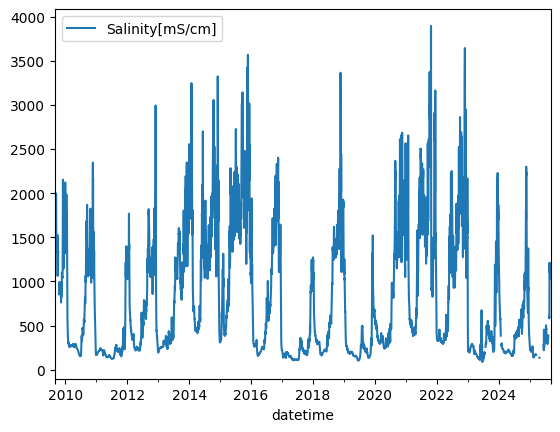

In [6]:
#load the jersey point data, use the sjj signal to gap fill the jer, and load the holland cut salinity data, filter with cosine lanczos filter
jer_dms=pd.read_csv("/global/scratch/users/jennaisrael/climate_data_processing/identify_stp/dms_data_jer.csv")
jer_dms=jer_dms.rename(columns={"screened/jer//usbr/JER/ec/microS/cm": "Salinity[mS/cm]"})
jer_dms['datetime']=pd.to_datetime(jer_dms['datetime'],format=dtformat)
jer_dms.set_index("datetime",inplace=True)


sjj_dms=pd.read_csv("/global/scratch/users/jennaisrael/climate_data_processing/identify_stp/dms_data_sjj.csv")
sjj_dms=sjj_dms.rename(columns={"screened/sjj//usgs/11337190/ec/microS/cm": "Salinity[mS/cm]"})
sjj_dms['datetime']=pd.to_datetime(sjj_dms['datetime'],format=dtformat)
sjj_dms.set_index("datetime",inplace=True)

#gapfill
jp=jer_dms.fillna(sjj_dms)
jp=jp.asfreq('15min')
jp_filt=filter_timeseries(jp)

hol2_dms=pd.read_csv("/global/scratch/users/jennaisrael/climate_data_processing/identify_stp/dms_data_hol2.csv")
hol2_dms=hol2_dms.rename(columns={"screened/hol2//dwr_ncro/B95120/ec/microS/cm": "Salinity[mS/cm]"})
hol2_dms['datetime']=pd.to_datetime(hol2_dms['datetime'],format=dtformat)
hol2_dms.set_index("datetime",inplace=True)
hol2_dms=hol2_dms.asfreq('15min')
hol2_dms_filt=filter_timeseries(hol2_dms)

frk=pd.read_csv('/global/scratch/users/jennaisrael/climate_data_processing/identify_stp/frkdefault_ec_screened_2021.csv',skiprows=65)#.set_index('datetime')
frk=frk.rename(columns={"value": "Salinity[mS/cm]"})
frk['datetime']=pd.to_datetime(frk['datetime'],format=dtformat)
frk.set_index("datetime",inplace=True)
frk=frk.asfreq('15min')
frk_filt=filter_timeseries(frk.drop(columns=['user_flag']))

jp_filt.plot()

In [7]:
frk_filt

,Salinity[mS/cm]
datetime,
2015-07-01 00:00:00,NaN
2015-07-01 00:15:00,NaN
2015-07-01 00:30:00,NaN
2015-07-01 00:45:00,NaN
2015-07-01 01:00:00,NaN
...,...
2025-07-14 17:00:00,NaN
2025-07-14 17:15:00,NaN
2025-07-14 17:30:00,NaN


In [8]:
# # save these 2 filtered datasets so we don't have to keep doing this
# jp_filt.to_csv("/global/scratch/users/jennaisrael/time_varying_data/salinity/jersey_point_jer_sjj_filled_cl_filtered.csv")
# hol2_dms_filt.to_csv("/global/scratch/users/jennaisrael/time_varying_data/salinity/holland_cut_hol2_cl_filtered.csv")

# DO NOT DOWNSAMPLE THE SALINITY DATA

In [9]:
# #downsample the salinity data to also be every half hour
# jp_filt=jp_filt.resample('30min').mean()
# hol2_dms_filt=hol2_dms_filt.resample('30min').mean()

In [10]:
#what are the time frames of these data?
print("Point Reyes SCHA & BC filt time range: "+str(pr_filt.first_valid_index())+" - "+str(pr_filt.last_valid_index()))
print("Jersey Point time range: "+str(jp_filt.first_valid_index())+" - "+str(jp_filt.last_valid_index()))
print("Franks Tract time range: "+str(frk_filt.first_valid_index())+" - "+str(frk_filt.last_valid_index()))
print("Holland Cut time range: "+str(hol2_dms_filt.first_valid_index())+" - "+str(hol2_dms_filt.last_valid_index()))


Point Reyes SCHA & BC filt time range: 2012-02-12 01:30:00 - 2023-11-19 22:30:00
Jersey Point time range: 2009-09-04 15:00:00 - 2025-08-29 01:30:00
Franks Tract time range: 2015-07-05 04:00:00 - 2025-07-10 14:00:00
Holland Cut time range: 2009-09-07 16:00:00 - 2025-09-03 19:00:00


# Confine our search to water years 2013 to 2024

In [11]:
# # Try out python's peak finding method in the signal toolbox
# pr_trim=pr_filt.Residual[2000:3000].values
# peaks, _ = find_peaks(pr_trim, height=0)

# plt.plot(pr_trim)

# plt.plot(peaks, pr_trim[peaks], "x")

# plt.plot(np.zeros_like(pr_trim), "--", color="gray")

# plt.show()


In [12]:
# #repeat for salinity (harder)
# jp_trim=jp_filt['Salinity[mS/cm]'][2000:3000].values
# peaks, _ = find_peaks(jp_trim, height=0)

# plt.plot(jp_trim)

# plt.plot(peaks, jp_trim[peaks], "x")

# plt.plot(np.zeros_like(jp_trim), "--", color="gray")

# plt.show()

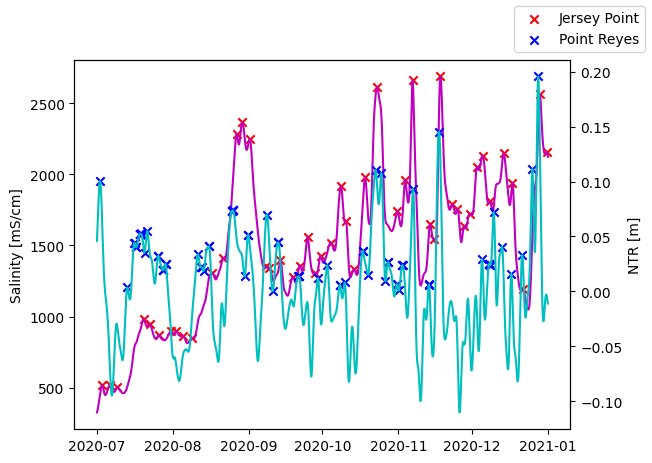

47 peaks identified for Jersey Point
85 peaks identified for Point Reyes


In [13]:
#try instead looking at a range we have examined previously 
jp_f2020=jp_filt['Salinity[mS/cm]'].loc[datetime(2020,7,1):datetime(2021,1,1)].values
pr_f2020=pr_filt['Residual'].loc[datetime(2020,7,1):datetime(2021,1,1)].values
peaksjp, _ = find_peaks(jp_f2020, height=0)
peakspr, _ = find_peaks(pr_f2020, height=0)

fig, ax= plt.subplots(sharex=True)
ax.plot(jp_filt.loc[datetime(2020,7,1):datetime(2021,1,1)].index,jp_filt.loc[datetime(2020,7,1):datetime(2021,1,1)],color='m')
ax.scatter(jp_filt.loc[datetime(2020,7,1):datetime(2021,1,1)].iloc[peaksjp].index, jp_f2020[peaksjp], label="Jersey Point",marker="x",color='r')
#ax.plot(np.zeros_like(jp_f2020), "--", color="gray")
ax.set_ylabel('Salinity [mS/cm]')

ax2=ax.twinx() 
ax2.plot(pr_filt.loc[datetime(2020,7,1):datetime(2021,1,1)].index,pr_filt.loc[datetime(2020,7,1):datetime(2021,1,1)],color='c')
ax2.scatter(pr_filt.loc[datetime(2020,7,1):datetime(2021,1,1)].iloc[peakspr].index, pr_f2020[peakspr], label="Point Reyes",marker="x",color='b')
#ax2.plot(np.zeros_like(pr_f2020), "--", color="gray")
ax2.set_ylabel('NTR [m]')

fig.legend()

plt.show()
print(str(len(peaksjp))+' peaks identified for Jersey Point')
print(str(len(peakspr))+' peaks identified for Point Reyes')

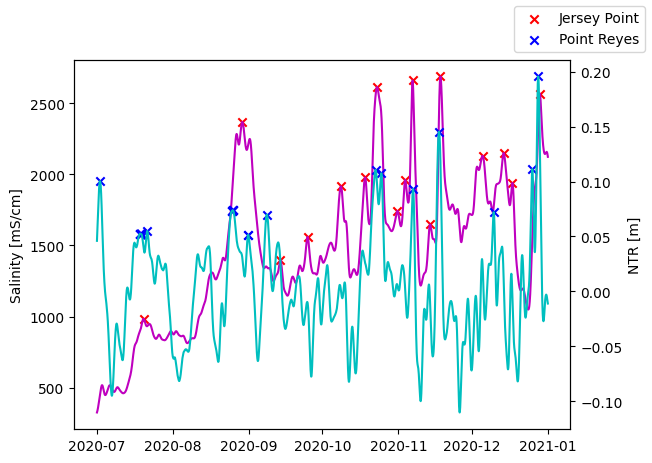

16 peaks identified for Jersey Point
30 peaks identified for Point Reyes


In [14]:
#repeat but with a threshold for prominence 
peaksjp, _ = find_peaks(jp_f2020, prominence=100)
peakspr, _ = find_peaks(pr_f2020, height=0.05)

fig, ax= plt.subplots(sharex=True)
ax.plot(jp_filt.loc[datetime(2020,7,1):datetime(2021,1,1)].index,jp_filt.loc[datetime(2020,7,1):datetime(2021,1,1)],color='m')
ax.scatter(jp_filt.loc[datetime(2020,7,1):datetime(2021,1,1)].iloc[peaksjp].index, jp_f2020[peaksjp], label="Jersey Point",marker="x",color='r')
#ax.plot(np.zeros_like(jp_f2020), "--", color="gray")
ax.set_ylabel('Salinity [mS/cm]')

ax2=ax.twinx() 
ax2.plot(pr_filt.loc[datetime(2020,7,1):datetime(2021,1,1)].index,pr_filt.loc[datetime(2020,7,1):datetime(2021,1,1)],color='c')
ax2.scatter(pr_filt.loc[datetime(2020,7,1):datetime(2021,1,1)].iloc[peakspr].index, pr_f2020[peakspr], label="Point Reyes",marker="x",color='b')
#ax2.plot(np.zeros_like(pr_f2020), "--", color="gray")
ax2.set_ylabel('NTR [m]')

fig.legend()

plt.show()
print(str(len(peaksjp))+' peaks identified for Jersey Point')
print(str(len(peakspr))+' peaks identified for Point Reyes')

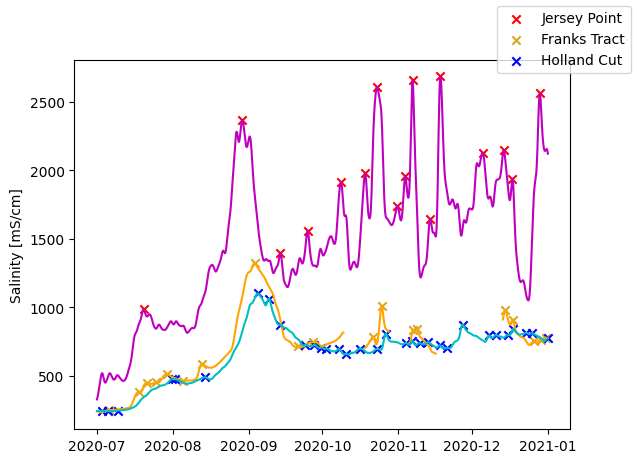

16 peaks identified for Jersey Point
19 peaks identified for Franks Tract
32 peaks identified for Holland Cut


In [15]:
#Salinity 
frk_f2020=frk_filt['Salinity[mS/cm]'].loc[datetime(2020,7,1):datetime(2021,1,1)].values
peaksfrk, _ = find_peaks(frk_f2020, height=0)
hol2_f2020=hol2_dms_filt['Salinity[mS/cm]'].loc[datetime(2020,7,1):datetime(2021,1,1)].values
peakshol2, _ = find_peaks(hol2_f2020, height=0)

fig, ax= plt.subplots(sharex=True)
ax.plot(jp_filt.loc[datetime(2020,7,1):datetime(2021,1,1)].index,jp_filt.loc[datetime(2020,7,1):datetime(2021,1,1)],color='m')
ax.scatter(jp_filt.loc[datetime(2020,7,1):datetime(2021,1,1)].iloc[peaksjp].index, jp_f2020[peaksjp], label="Jersey Point",marker="x",color='r')
ax.set_ylabel('Salinity [mS/cm]')
#plot salinity on the same axis this time

#ax.plot(frk_f2020,color='orange')
ax.plot(frk_filt.loc[datetime(2020,7,1):datetime(2021,1,1)].index, frk_filt.loc[datetime(2020,7,1):datetime(2021,1,1)],color='orange')
ax.scatter(frk_filt.loc[datetime(2020,7,1):datetime(2021,1,1)].iloc[peaksfrk].index, frk_f2020[peaksfrk], label="Franks Tract",marker="x",color='goldenrod')
#ax.plot(np.zeros_like(frk_f2020), "--", color="gray")


ax.plot(hol2_dms_filt.loc[datetime(2020,7,1):datetime(2021,1,1)].index, hol2_dms_filt.loc[datetime(2020,7,1):datetime(2021,1,1)],color='c')
ax.scatter(hol2_dms_filt.loc[datetime(2020,7,1):datetime(2021,1,1)].iloc[peakshol2].index, hol2_f2020[peakshol2], label="Holland Cut",marker="x",color='b')


fig.legend()

plt.show()
print(str(len(peaksjp))+' peaks identified for Jersey Point')
print(str(len(peaksfrk))+' peaks identified for Franks Tract')
print(str(len(peakshol2))+' peaks identified for Holland Cut')


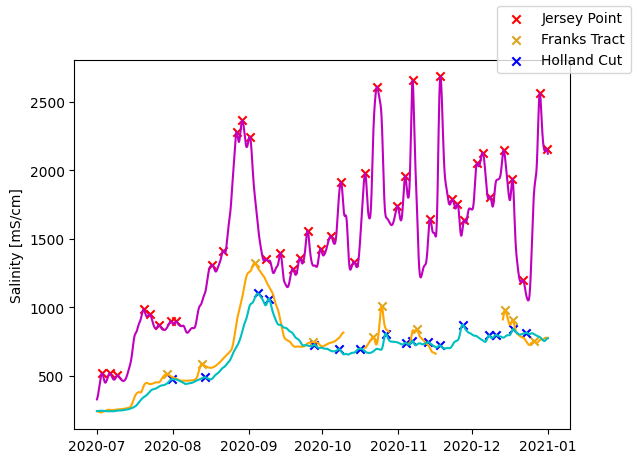

40 peaks identified for Jersey Point
10 peaks identified for Franks Tract
17 peaks identified for Holland Cut


In [16]:
# probably need a minimum peak height for salinity
peaksjp10, _ = find_peaks(jp_f2020, prominence=10) #height is relative to 0! Not relative to the local "baseline", prominence is relative to baseline
peakshol210, _ = find_peaks(hol2_f2020, prominence=10)
peaksfrk10, _ = find_peaks(frk_f2020, prominence=10)

fig, ax= plt.subplots(sharex=True)
ax.plot(jp_filt.loc[datetime(2020,7,1):datetime(2021,1,1)].index,jp_filt.loc[datetime(2020,7,1):datetime(2021,1,1)],color='m')
ax.scatter(jp_filt.loc[datetime(2020,7,1):datetime(2021,1,1)].iloc[peaksjp10].index, jp_f2020[peaksjp10], label="Jersey Point",marker="x",color='r')
ax.set_ylabel('Salinity [mS/cm]')
#plot salinity on the same axis this time

#ax.plot(frk_f2020,color='orange')
ax.plot(frk_filt.loc[datetime(2020,7,1):datetime(2021,1,1)].index, frk_filt.loc[datetime(2020,7,1):datetime(2021,1,1)],color='orange')
ax.scatter(frk_filt.loc[datetime(2020,7,1):datetime(2021,1,1)].iloc[peaksfrk10].index, frk_f2020[peaksfrk10], label="Franks Tract",marker="x",color='goldenrod')
#ax.plot(np.zeros_like(frk_f2020), "--", color="gray")


ax.plot(hol2_dms_filt.loc[datetime(2020,7,1):datetime(2021,1,1)].index, hol2_dms_filt.loc[datetime(2020,7,1):datetime(2021,1,1)],color='c')
ax.scatter(hol2_dms_filt.loc[datetime(2020,7,1):datetime(2021,1,1)].iloc[peakshol210].index, hol2_f2020[peakshol210], label="Holland Cut",marker="x",color='b')


fig.legend()

plt.show()
print(str(len(peaksjp10))+' peaks identified for Jersey Point')
print(str(len(peaksfrk10))+' peaks identified for Franks Tract')
print(str(len(peakshol210))+' peaks identified for Holland Cut')

# Can we use the max cross-correlation (lag) to inform this analysis?

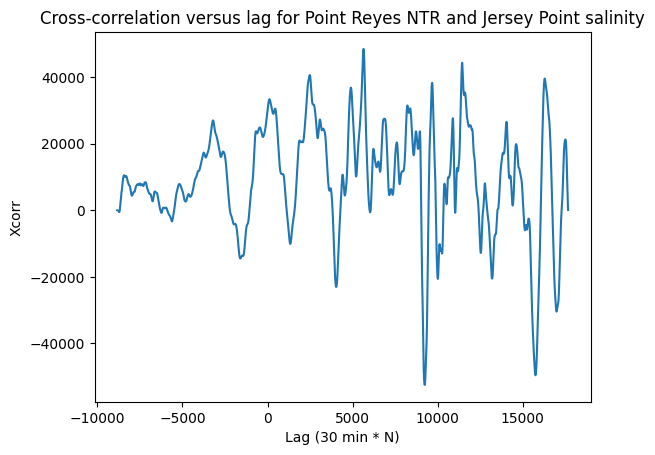

Lag of max cross-correlation is 2822.0 hours


In [17]:
corr = correlate(jp_f2020, pr_f2020)
lags = correlation_lags(len(jp_f2020), len(pr_f2020))
fig, ax= plt.subplots()
ax.plot(lags,corr)
ax.set_xlabel('Lag (30 min * N)')
ax.set_ylabel('Xcorr')
ax.set_title('Cross-correlation versus lag for Point Reyes NTR and Jersey Point salinity')
plt.show()
print('Lag of max cross-correlation is '+ str(lags[corr.argmax()]*0.5)+ ' hours')

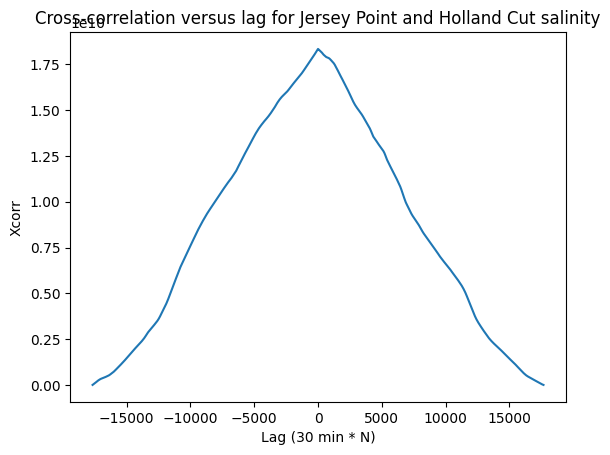

Lag of max cross-correlation is 0.0 hours


In [18]:
# What about holland cut and jersey point?
corr = correlate(hol2_f2020, jp_f2020)
lags = correlation_lags(len(hol2_f2020), len(jp_f2020))
fig, ax= plt.subplots()
ax.plot(lags,corr)
ax.set_xlabel('Lag (30 min * N)')
ax.set_ylabel('Xcorr')
ax.set_title('Cross-correlation versus lag for Jersey Point and Holland Cut salinity')
plt.show()
print('Lag of max cross-correlation is '+ str(lags[corr.argmax()]*0.5)+ ' hours')

In [19]:
# #load the jersey point data, use the sjj signal to gap fill the jer, and load the holland cut salinity data, filter with cosine lanczos filter
# jer_dms=pd.read_csv("/global/scratch/users/jennaisrael/climate_data_processing/identify_stp/dms_data_jer.csv")
# jer_dms=jer_dms.rename(columns={"screened/jer//usbr/JER/ec/microS/cm": "Salinity[mS/cm]"})
# jer_dms['datetime']=pd.to_datetime(jer_dms['datetime'],format=dtformat)
# jer_dms.set_index("datetime",inplace=True)


# sjj_dms=pd.read_csv("/global/scratch/users/jennaisrael/climate_data_processing/identify_stp/dms_data_sjj.csv")
# sjj_dms=sjj_dms.rename(columns={"screened/sjj//usgs/11337190/ec/microS/cm": "Salinity[mS/cm]"})
# sjj_dms['datetime']=pd.to_datetime(sjj_dms['datetime'],format=dtformat)
# sjj_dms.set_index("datetime",inplace=True)

# #gapfill
# jp=jer_dms.fillna(sjj_dms)
# jp=jp.asfreq('15min')
# jp_filt=filter_timeseries(jp)

# hol2_dms=pd.read_csv("/global/scratch/users/jennaisrael/climate_data_processing/identify_stp/dms_data_hol2.csv")
# hol2_dms=hol2_dms.rename(columns={"screened/hol2//dwr_ncro/B95120/ec/microS/cm": "Salinity[mS/cm]"})
# hol2_dms['datetime']=pd.to_datetime(hol2_dms['datetime'],format=dtformat)
# hol2_dms.set_index("datetime",inplace=True)
# hol2_dms=hol2_dms.asfreq('15min')
# hol2_dms_filt=filter_timeseries(hol2_dms)


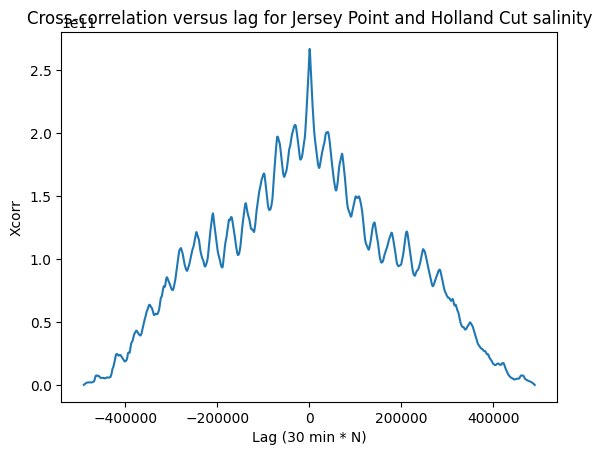

Lag of max cross-correlation is 173.75 hours


In [20]:
# Does this change if we look at a longer signal and go back to the 15 minute version?
hol2_x=hol2_dms_filt['Salinity[mS/cm]'].loc[datetime(2010,9,8):datetime(2024,8,28)].interpolate().values # need to fill the gaps to calculate the cross correlation
jp_x=jp_filt['Salinity[mS/cm]'].loc[datetime(2010,9,8):datetime(2024,8,28)].interpolate().values
corr = correlate(hol2_x, jp_x)
lags = correlation_lags(len(hol2_x), len(jp_x))
fig, ax= plt.subplots()
ax.plot(lags,corr)
ax.set_xlabel('Lag (30 min * N)')
ax.set_ylabel('Xcorr')
ax.set_title('Cross-correlation versus lag for Jersey Point and Holland Cut salinity')
plt.show()
print('Lag of max cross-correlation is '+ str(lags[corr.argmax()]*0.25)+ ' hours')

# Identify subtidal pumping events

In [21]:
#put all the variables in one array, need to cut it off before the last array begins (pr 2012-02-12) and before the first array ends (pr 2023-11-19)
df_raw=pd.concat([pr_filt.rename(columns={"Residual": "pr"}),jp_filt.rename(columns={"Salinity[mS/cm]": "jp"}),frk_filt.rename(columns={"Salinity[mS/cm]": "frk"}),hol2_dms_filt.rename(columns={"Salinity[mS/cm]": "hol2"})],axis=1)
df=df_raw.loc[datetime(2012,2,13):datetime(2023,11,18)]#.interpolate()

In [22]:
df

,pr,jp,frk,hol2
datetime,,,,
2012-02-13 00:00:00,0.084324,471.958898,NaN,497.825359
2012-02-13 00:15:00,NaN,471.996861,NaN,497.718607
2012-02-13 00:30:00,0.082788,472.032057,NaN,497.610584
2012-02-13 00:45:00,NaN,472.064334,NaN,497.501297
2012-02-13 01:00:00,0.081049,472.093539,NaN,497.390752
...,...,...,...,...
2023-11-17 23:00:00,0.206520,1067.342768,205.590816,216.022549
2023-11-17 23:15:00,NaN,1069.722160,205.787840,216.071901
2023-11-17 23:30:00,0.207101,1072.129574,205.988822,216.120777


In [23]:
df['datetime']=df.index.values
df['month']=df.index.month.values
df['year']=df.index.year.values
df

/global/home/users/jennaisrael/.conda/envs/schimpy/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/global/home/users/jennaisrael/.conda/envs/schimpy/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/global/home/users/jennaisrael/.conda/envs/schimpy/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a c

,pr,jp,frk,hol2,datetime,month,year
datetime,,,,,,,
2012-02-13 00:00:00,0.084324,471.958898,NaN,497.825359,2012-02-13 00:00:00,2,2012
2012-02-13 00:15:00,NaN,471.996861,NaN,497.718607,2012-02-13 00:15:00,2,2012
2012-02-13 00:30:00,0.082788,472.032057,NaN,497.610584,2012-02-13 00:30:00,2,2012
2012-02-13 00:45:00,NaN,472.064334,NaN,497.501297,2012-02-13 00:45:00,2,2012
2012-02-13 01:00:00,0.081049,472.093539,NaN,497.390752,2012-02-13 01:00:00,2,2012
...,...,...,...,...,...,...,...
2023-11-17 23:00:00,0.206520,1067.342768,205.590816,216.022549,2023-11-17 23:00:00,11,2023
2023-11-17 23:15:00,NaN,1069.722160,205.787840,216.071901,2023-11-17 23:15:00,11,2023
2023-11-17 23:30:00,0.207101,1072.129574,205.988822,216.120777,2023-11-17 23:30:00,11,2023


In [24]:
# df_test=df.mask((df['month']<7) | (df['month']>11)|(df['year']==2021))
# df_test.pr.plot()


In [25]:
#I think I need to do this with a mask
#df.mask((df['A'] > 5) | (df['B'] < 3), 99)
# df_f_wo21=df.mask((df['month']<7) | (df['month']>11)|(df['year']==2021)|(df['year']==2022))
df_f_wo21=df.mask((df['month']<7) |(df['year']==2021)|(df['year']==2022)) #try leaving in december

In [26]:
maxw=60*24*4
minw=2
peakspr, propertiespr = find_peaks(df_f_wo21.pr.dropna().values, height=0,width=(2,maxw))

In [27]:
propertiespr["left_ips"]
#, ‘right_thresholds’

array([  135.73434394,   537.59290541,   626.24160283,   853.86645142,
        1039.79210249,  1216.9489214 ,  1544.9020367 ,  1977.09748676,
        1944.07245558,  2519.09749684,  2761.01782057,  2866.26399442,
        3053.83793363,  3189.3659344 ,  3432.44073119,  4080.64877134,
        4401.65596161,  4806.60801273,  5216.12032429,  5304.14982183,
        5195.43475619,  5702.58335206,  5813.38806161,  6113.12440244,
        6222.83423619,  6634.19410247,  6814.87147919,  7106.63283828,
        7202.3337544 ,  7167.48124477,  7373.89035604,  7505.67091321,
        7831.00673348,  7947.86730455,  8051.84513017,  8279.65526591,
        8404.04077758,  8507.74129414,  8665.18443319,  8831.95414994,
        8890.08426966,  9088.2509612 ,  9415.75707011,  9514.70111449,
        9773.76761925, 10091.12356351, 11007.41822323, 11174.13987195,
       11122.43420375, 11390.76297578, 11802.76360678, 12098.13925524,
       12518.83991826, 12719.23985801, 12702.73322568, 12870.55915017,
      

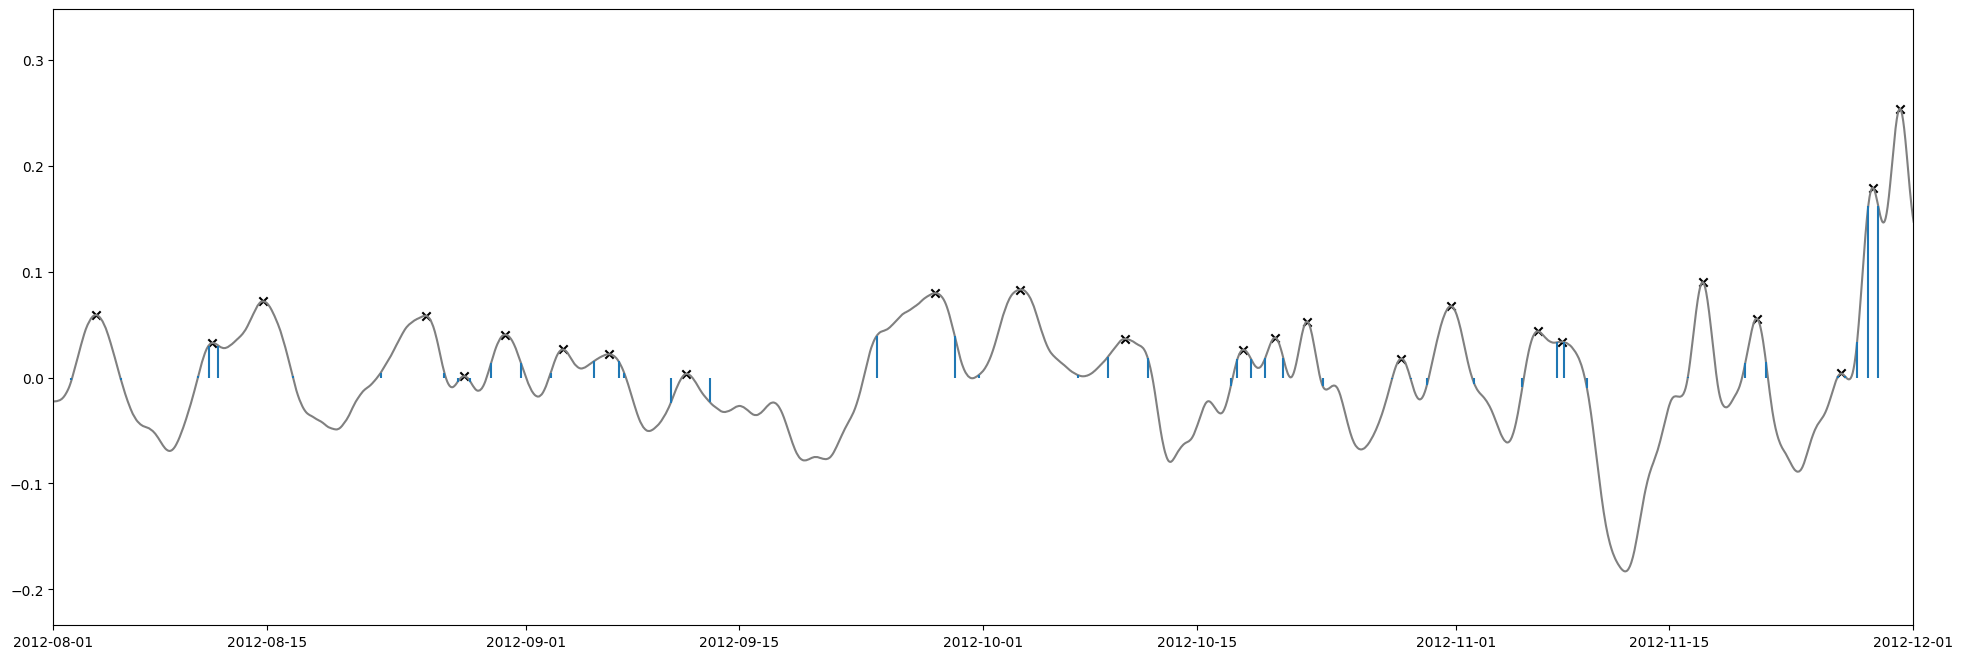

In [28]:
#calculate peak areas given the properties object from find_peaks
properties=propertiespr
y=df_f_wo21.pr.dropna().values
x=df_f_wo21.pr.dropna().index
left=properties["left_ips"]
right=properties["right_ips"]
lind=np.round(left).astype(int)
rind=np.round(right).astype(int)
fig,ax =plt.subplots(figsize=(24,8))
#ax.plot(x,y,color='grey')
ax.plot(x,y,color='grey')
ax.scatter(x[peakspr], df_f_wo21.pr.dropna().iloc[peakspr], label="Point Reyes",marker="x",color='k')
ax.vlines(x=x[lind],ymin=0,ymax=y[lind])
ax.vlines(x=x[rind],ymin=0,ymax=y[rind])

ax.set_xlim([datetime(2012,8,1),datetime(2012,12,1)])
plt.show()

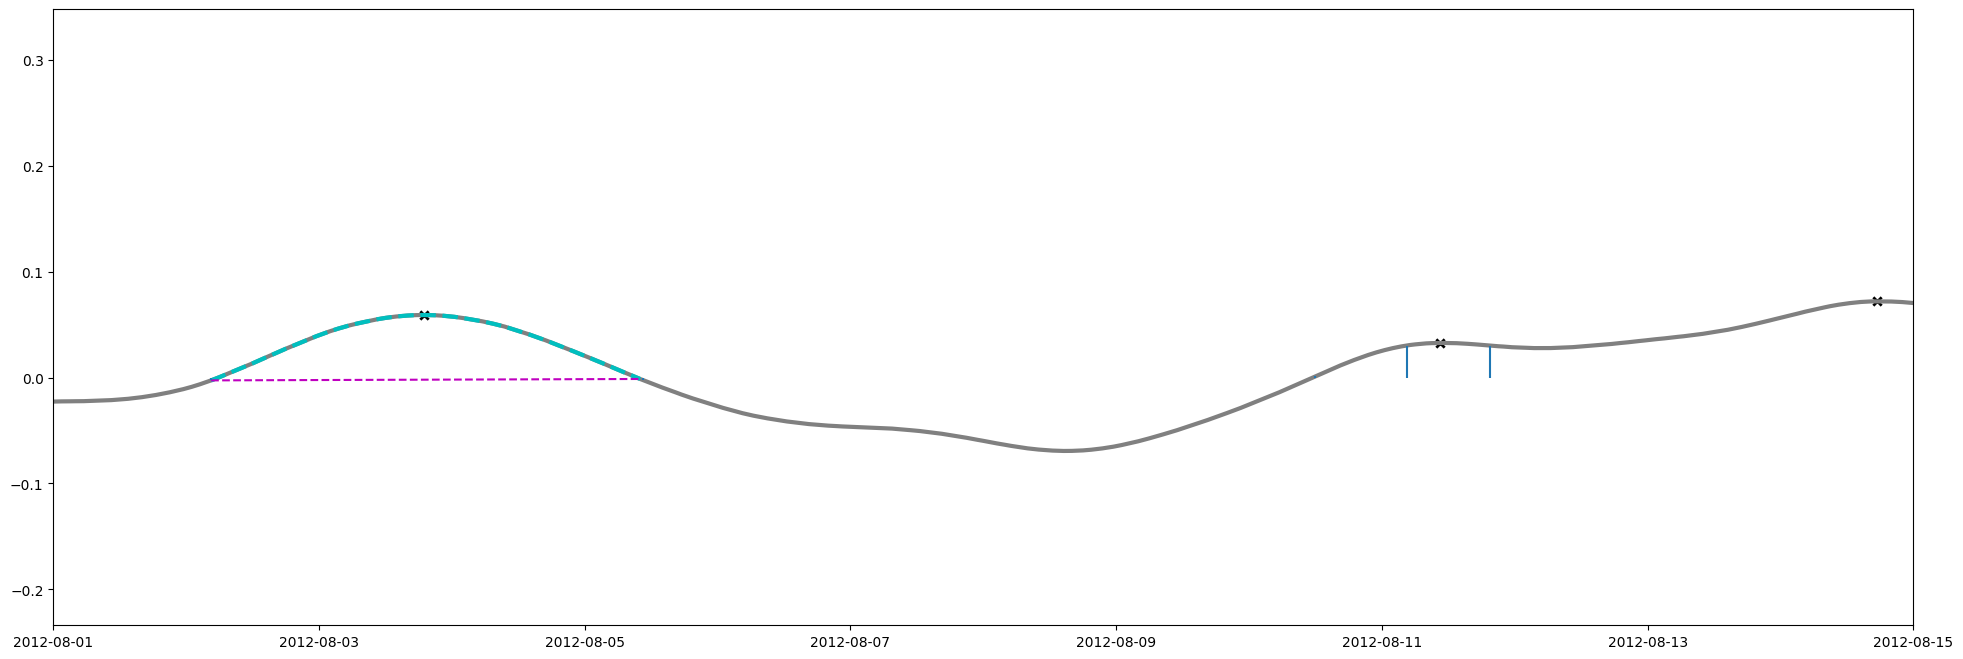

In [29]:
areav=np.array([])
p=6
if p==6:
#for p in np.arange(0,len(lind)):
    #print(p)
    peak=y[lind[p]:rind[p]]
    total_area = trapz(peak,dx=0.5) #need to pass the values between the left and right
    #now subtract the area from 0 to the peak, straight line between y[lind[p]] and y[rind[p]], should be the same length as peak
    n_points=len(peak)
    peak_bottom=np.linspace(peak[0],peak[len(peak)-1],num=n_points,endpoint=True)
    area_bottom=trapz(peak_bottom,dx=0.5) #dx is half an hour
    area=total_area-area_bottom
    #print(area)
    areav=np.append(areav, area)
    #30 minute time resolution = .5 hours
areav #units of elevation in m X time in hours
fig,ax =plt.subplots(figsize=(24,8))
#ax.plot(x,y,color='grey')
ax.plot(x,y,color='grey',linewidth=3)
#check that we are selecting the right area of the peak
ax.scatter(x[peakspr], df_f_wo21.pr.dropna().iloc[peakspr], label="Point Reyes",marker="x",color='k',linewidth=2)
ax.plot(x[lind[p]:rind[p]],peak,linestyle='--',color='c',linewidth=3)
ax.plot(x[lind[p]:rind[p]],peak_bottom,linestyle='--',color='m')
ax.vlines(x=x[lind],ymin=0,ymax=y[lind])
ax.vlines(x=x[rind],ymin=0,ymax=y[rind])

ax.set_xlim([datetime(2012,8,1),datetime(2012,8,15)])
plt.show()

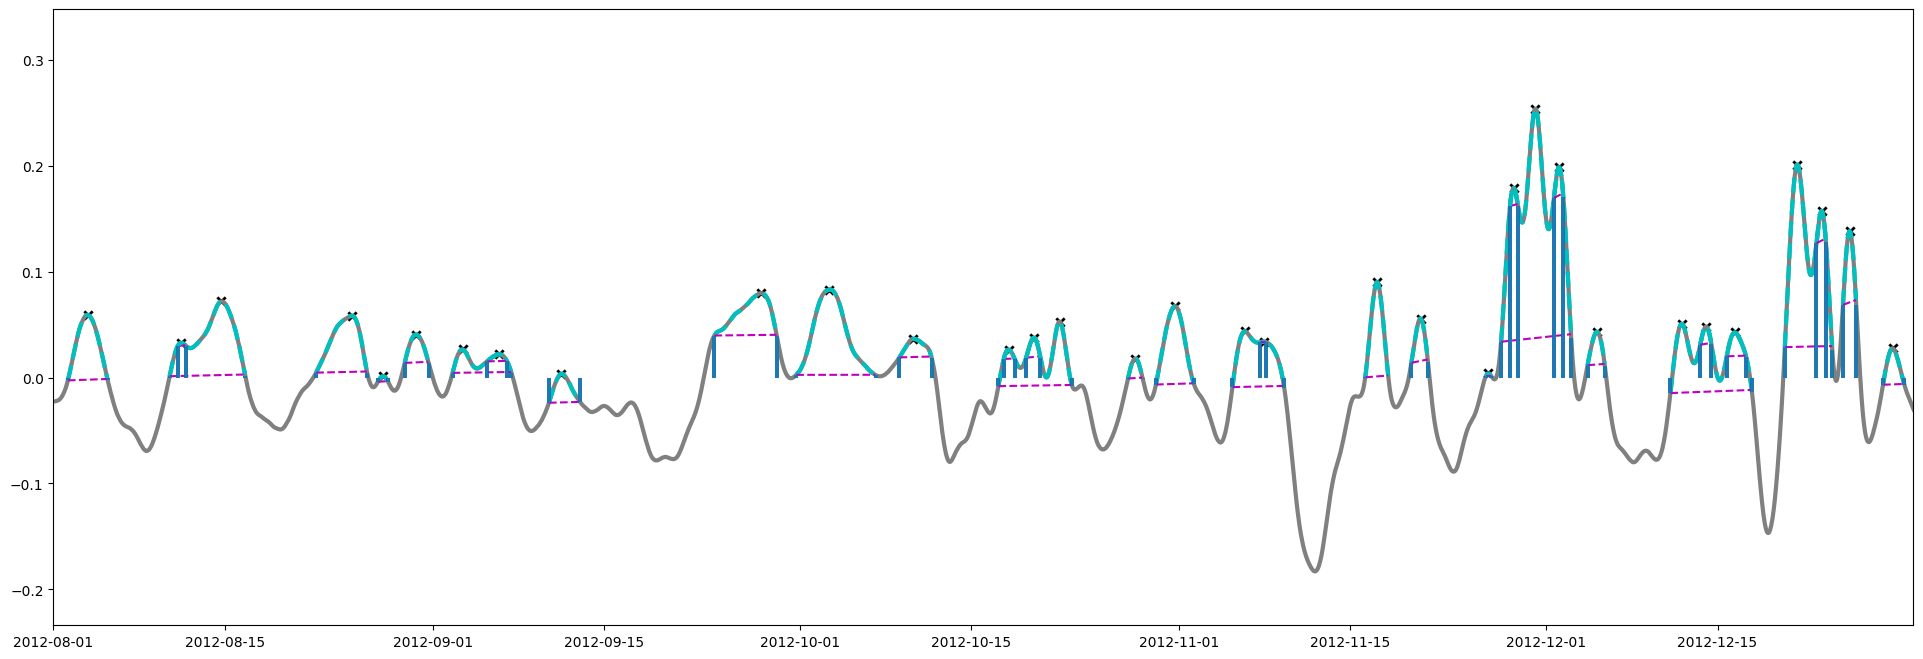

In [30]:
areav=np.array([])
fig,ax =plt.subplots(figsize=(24,8))
ax.plot(x,y,color='grey',linewidth=3)
ax.scatter(x[peakspr], df_f_wo21.pr.dropna().iloc[peakspr], label="Point Reyes",marker="x",color='k',linewidth=2)

for p in np.arange(0,len(lind)):
    #print(p)
    peak=y[lind[p]:rind[p]]
    total_area = trapz(peak,dx=0.5) #need to pass the values between the left and right
    #now subtract the area from 0 to the peak, straight line between y[lind[p]] and y[rind[p]], should be the same length as peak
    n_points=len(peak)
    peak_bottom=np.linspace(peak[0],peak[len(peak)-1],num=n_points,endpoint=True)
    area_bottom=trapz(peak_bottom,dx=0.5) #dx is half an hour
    area=total_area-area_bottom
    #print(area)
    areav=np.append(areav, area)
    #check that we are selecting the right area of the peak
    ax.plot(x[lind[p]:rind[p]],peak,linestyle='--',color='c',linewidth=3)
    ax.plot(x[lind[p]:rind[p]],peak_bottom,linestyle='--',color='m')
    ax.vlines(x=x[lind],ymin=0,ymax=y[lind])
    ax.vlines(x=x[rind],ymin=0,ymax=y[rind])
    #30 minute time resolution = .5 hours
areav #units of elevation in m X time in hours


ax.set_xlim([datetime(2012,8,1),datetime(2012,12,31)])
plt.show()

In [31]:
#calculate duration of events
dur=(rind-lind)*0.5 #duration in hours
dur

array([ 41. ,  25. , 133.5,  12. , 139.5,  31. ,  78. ,  15. , 148.5,
       100. ,  20. ,  47. , 115.5,  39.5,  61.5, 122.5, 155.5,  63. ,
        21.5,  28. , 144.5,  29. ,  74.5, 101.5,  11. ,  45.5,  32.5,
        11. ,  15.5, 137.5,  18.5,  34. , 160. ,  22. ,  38. ,  93. ,
        18.5,  26. ,  42. ,   3.5, 161. ,  39. ,  22.5,  35.5,  69.5,
       106.5,  24.5,  13. , 175.5,  10.5,  58.5, 177.5,  13. ,   4. ,
        96.5,   8. , 107. ,   5. , 119.5,  41.5,  64. ,  28. ,  16.5,
       129.5,  11. ,  37. , 112. ,  20.5,  66.5,  32. , 106. ,  16. ,
         5. , 126. ,  36. ,  13. , 129. , 133. ,   1.5,  14.5,  13.5,
       361.5,  37.5,  39.5,  41.5,  12. , 280.5,  70. ,  11.5,  91.5,
        12. , 139. ,  20.5,  46. , 218. ,  15.5,  34. ,  34. ,  59.5,
       131. ,  17.5,  98.5,   4. ,  38. ,  47.5,  15.5,  36. ,  63.5,
        73. ,   9.5,  11. ,  59.5,   8.5, 122. ,  99.5,  38.5,  16.5,
       178.5,  21. ,  59. , 171.5,  51.5,  66. , 295. ,  10.5,  67. ,
        24.5,   8. ,

In [32]:
#normalize area by duration (unit intensity)
inten_u=areav/dur

Text(0.5, 1.0, 'Event unit intensity (h*m/h)')

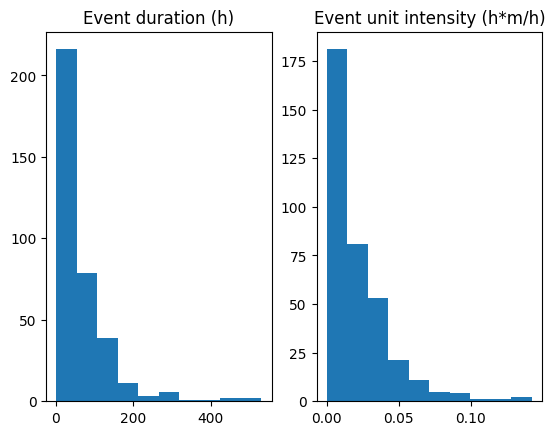

In [33]:
#first make duration and intensity histograms
fig, ax = plt.subplots(1,2)

ax[0].hist(dur)
ax[0].set_title('Event duration (h)')
ax[1].hist(inten_u)
ax[1].set_title('Event unit intensity (h*m/h)')


Text(0, 0.5, 'event unit intensity (h*m/h)')

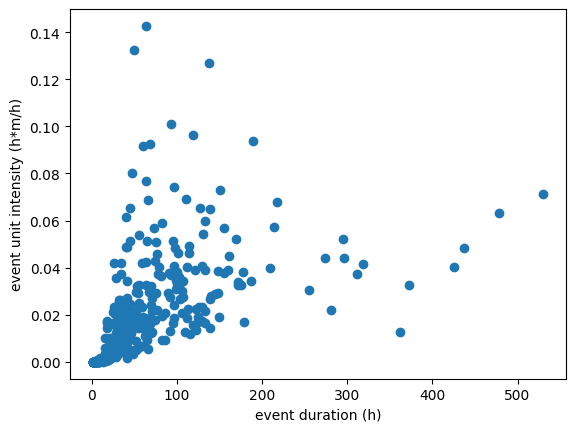

In [34]:
#plot intensity vs duration
fig, ax = plt.subplots()

ax.scatter(dur,inten_u)
ax.set_xlabel('event duration (h)')
ax.set_ylabel('event unit intensity (h*m/h)')

Text(0, 0.5, 'event unit intensity (h*m/h)')

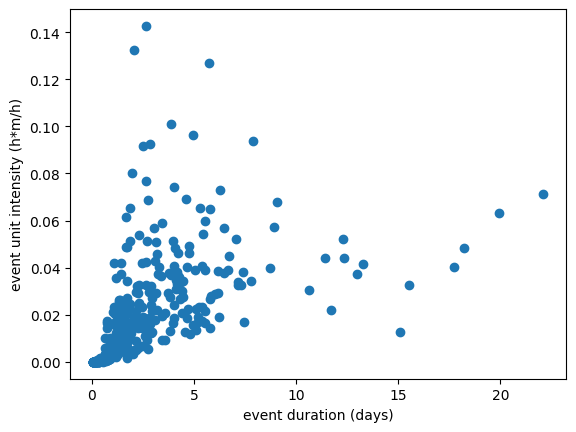

In [35]:
#plot intensity vs duration
fig, ax = plt.subplots()

ax.scatter(dur/24,inten_u)
ax.set_xlabel('event duration (days)')
ax.set_ylabel('event unit intensity (h*m/h)')

(0.0, 20.0)

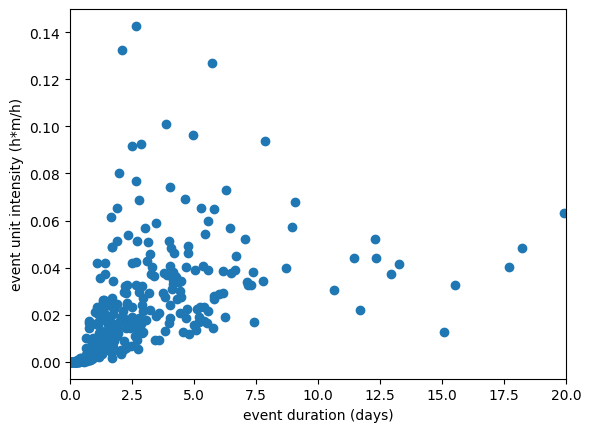

In [36]:
#plot intensity vs duration
fig, ax = plt.subplots()

ax.scatter(dur/24,inten_u)
ax.set_xlabel('event duration (days)')
ax.set_ylabel('event unit intensity (h*m/h)')
ax.set_xlim(0,20)

In [37]:
#partition by month, need cyclical color map
# actually because we are trimming the year to start in the summer does not make sense to do cylical
# first need to map the index to a date
# then extract month 
x[lind].month

Int64Index([ 7,  7,  7,  7,  7,  7,  8,  8,  8,  8,
            ...
            10, 10, 10, 10, 10, 10, 10, 10, 10, 11],
           dtype='int64', name='datetime', length=360)

In [38]:
#color vals
mcval=x[lind].month.values/12


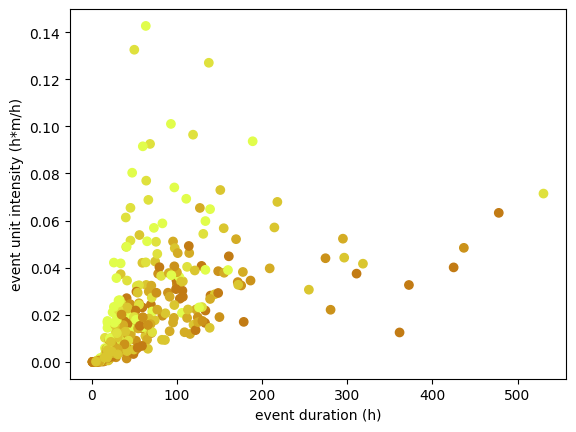

In [39]:
#cmocean phase is cyclical!
#plot intensity vs duration
fig, ax = plt.subplots()

ax.scatter(dur,inten_u, color=cmocean.cm.solar(mcval))
ax.set_xlabel('event duration (h)')
ax.set_ylabel('event unit intensity (h*m/h)')
plt.show()

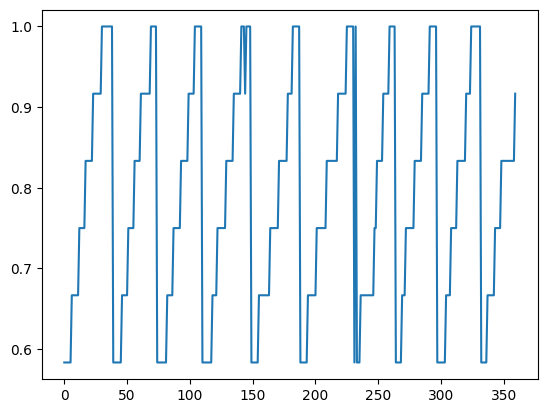

In [40]:
plt.plot(mcval)

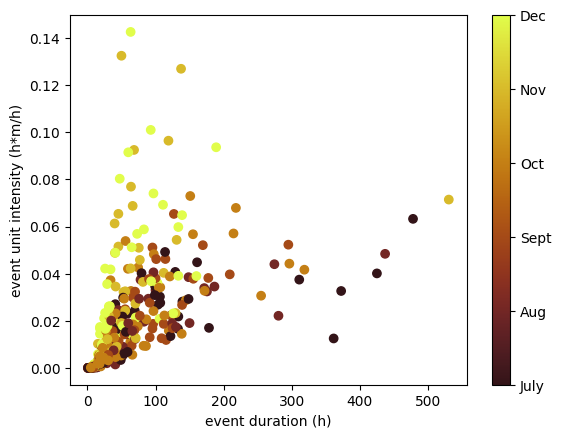

In [41]:
#add colorbar

fig, ax = plt.subplots()

pts=ax.scatter(dur,inten_u,c=x[lind].month,cmap=cmocean.cm.solar)
ax.set_xlabel('event duration (h)')
ax.set_ylabel('event unit intensity (h*m/h)')
cbar=fig.colorbar(pts, ax=ax)
cbar.set_ticks(ticks=np.arange(7,13), labels=['July','Aug','Sept','Oct','Nov','Dec'])
plt.show()

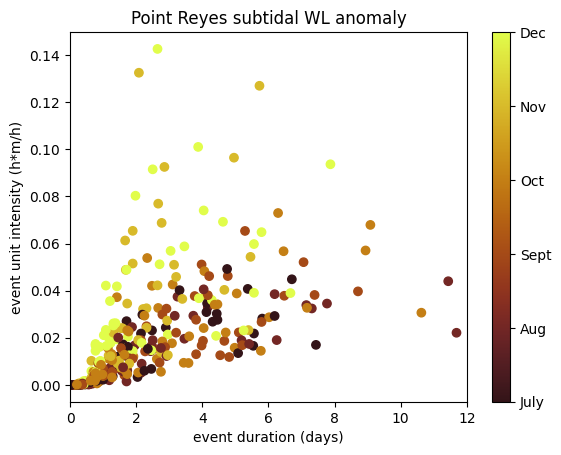

In [42]:
fig, ax = plt.subplots()

pts=ax.scatter(dur/24,inten_u,c=x[lind].month,cmap=cmocean.cm.solar)
ax.set_xlabel('event duration (days)')
ax.set_ylabel('event unit intensity (h*m/h)')
ax.set_xlim(0,12)
ax.set_title('Point Reyes subtidal WL anomaly')
cbar=fig.colorbar(pts, ax=ax)
cbar.set_ticks(ticks=np.arange(7,13), labels=['July','Aug','Sept','Oct','Nov','Dec'])
plt.show()

# Is the distribution the same for salinity at Jersey Point?

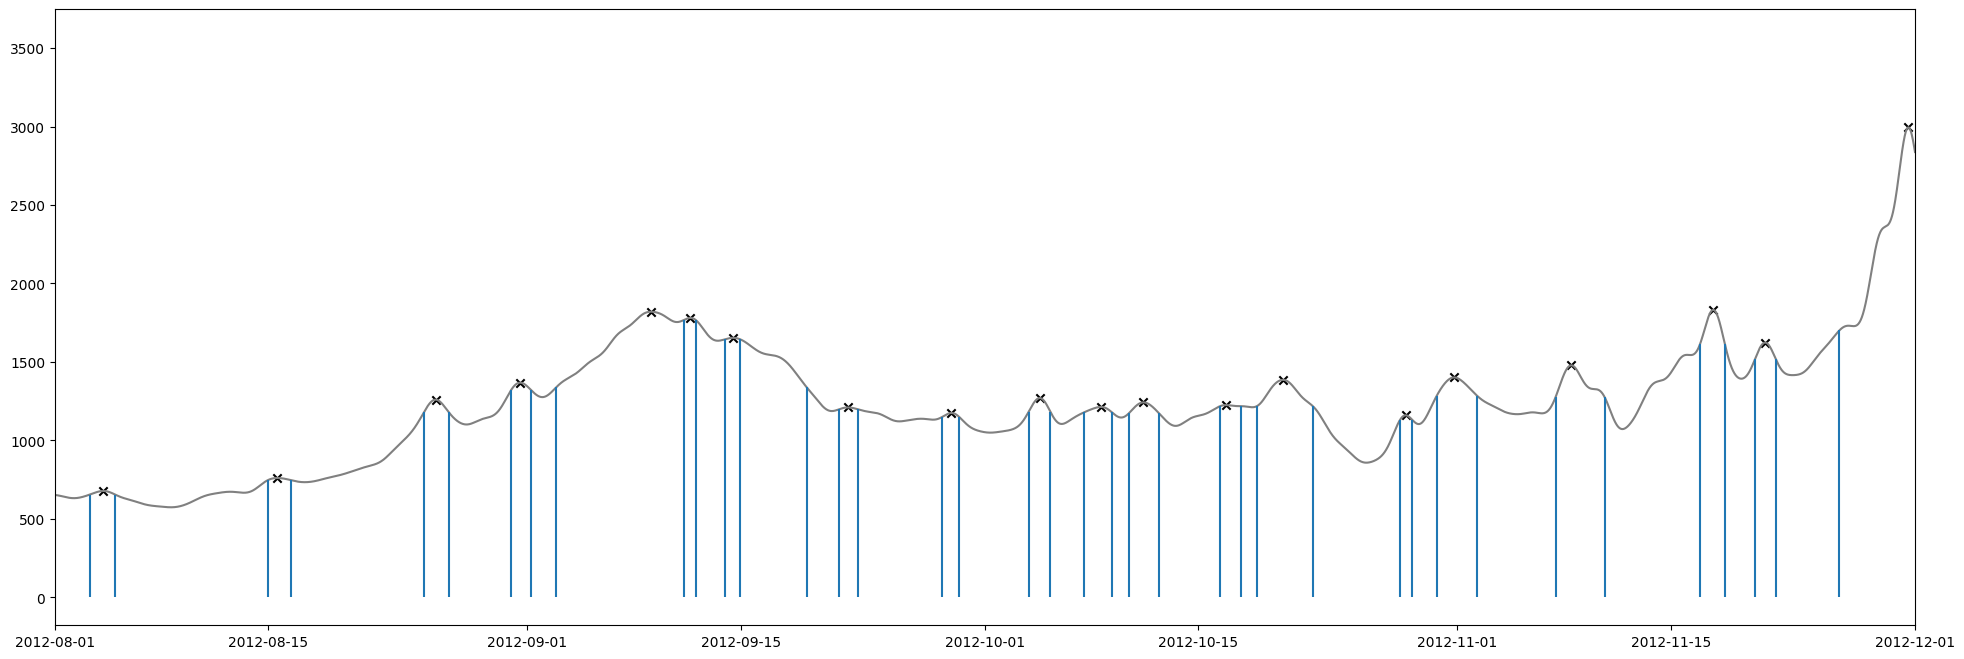

In [43]:
peaksjp, propertiesjp = find_peaks(df_f_wo21.jp.dropna().values, prominence=10,width=(0,maxw)) #need to pass range of widths or won't be able to extract left and right
y=df_f_wo21.jp.dropna().values
x=df_f_wo21.jp.dropna().index
left=propertiesjp["left_ips"]
right=propertiesjp["right_ips"]
lind=np.round(left).astype(int)
rind=np.round(right).astype(int)
fig,ax =plt.subplots(figsize=(24,8))
#ax.plot(x,y,color='grey')
ax.plot(x,y,color='grey')
ax.scatter(x[peaksjp], y[peaksjp], label="Jersey Point",marker="x",color='k')
ax.vlines(x=x[lind],ymin=0,ymax=y[lind])
ax.vlines(x=x[rind],ymin=0,ymax=y[rind])

ax.set_xlim([datetime(2012,8,1),datetime(2012,12,1)])
plt.show()

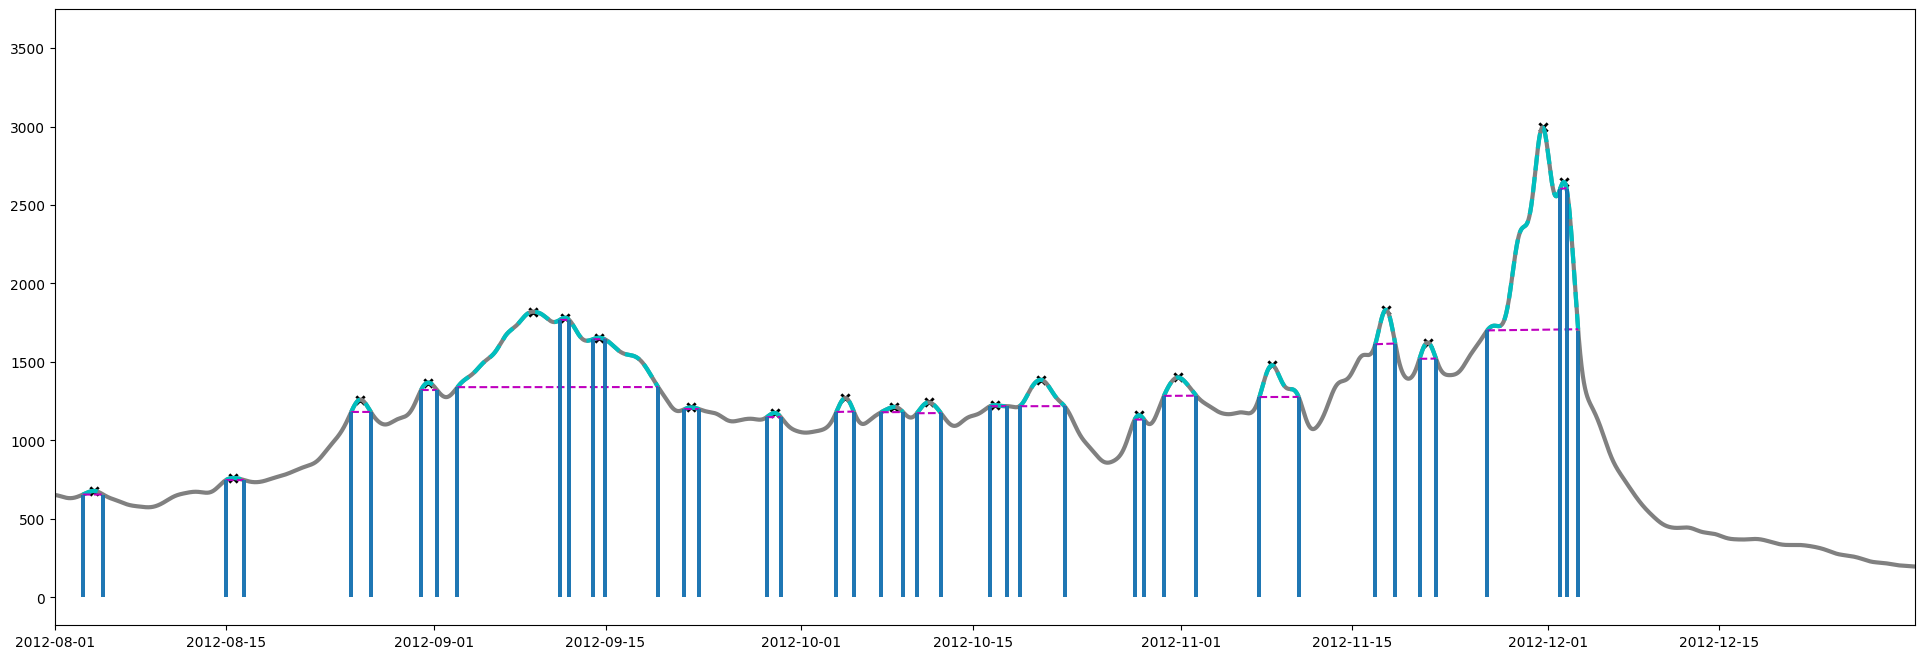

In [44]:
areav=np.array([])
fig,ax =plt.subplots(figsize=(24,8))
ax.plot(x,y,color='grey',linewidth=3)
ax.scatter(x[peaksjp], df_f_wo21.jp.dropna().iloc[peaksjp], label="Jersey Point",marker="x",color='k',linewidth=2)

for p in np.arange(0,len(lind)):
    #print(p)
    peak=y[lind[p]:rind[p]]
    total_area = trapz(peak,dx=0.25) #need to pass the values between the left and right
    #now subtract the area from 0 to the peak, straight line between y[lind[p]] and y[rind[p]], should be the same length as peak
    n_points=len(peak)
    peak_bottom=np.linspace(peak[0],peak[len(peak)-1],num=n_points,endpoint=True)
    area_bottom=trapz(peak_bottom,dx=0.25) #dx is half an hour
    area=total_area-area_bottom
    #print(area)
    areav=np.append(areav, area)
    #check that we are selecting the right area of the peak
    ax.plot(x[lind[p]:rind[p]],peak,linestyle='--',color='c',linewidth=3)
    ax.plot(x[lind[p]:rind[p]],peak_bottom,linestyle='--',color='m')
    ax.vlines(x=x[lind],ymin=0,ymax=y[lind])
    ax.vlines(x=x[rind],ymin=0,ymax=y[rind])
    #30 minute time resolution = .5 hours
areav #units of elevation in m X time in hours


ax.set_xlim([datetime(2012,8,1),datetime(2012,12,31)])
plt.show()

In [45]:
#calculate duration of events
dur=(rind-lind)*0.25 #duration in hours
#normalize area by duration (unit intensity)
inten_u=areav/dur


Text(0, 0.5, 'event unit intensity ($h*mS/cm^3 h^{-1}$)')

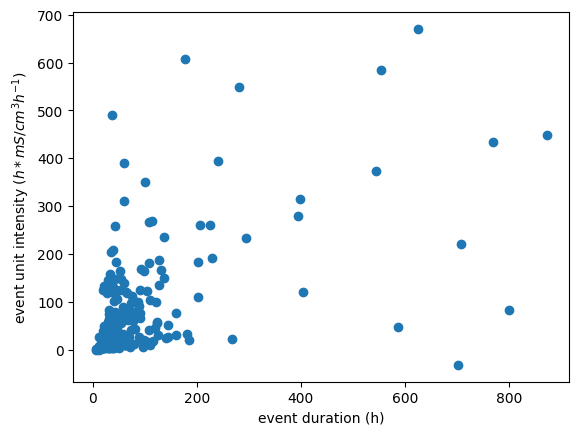

In [46]:
#plot intensity vs duration
fig, ax = plt.subplots()

ax.scatter(dur,inten_u)
ax.set_xlabel('event duration (h)')
ax.set_ylabel('event unit intensity ($h*mS/cm^3 h^{-1}$)')

(0.0, 20.0)

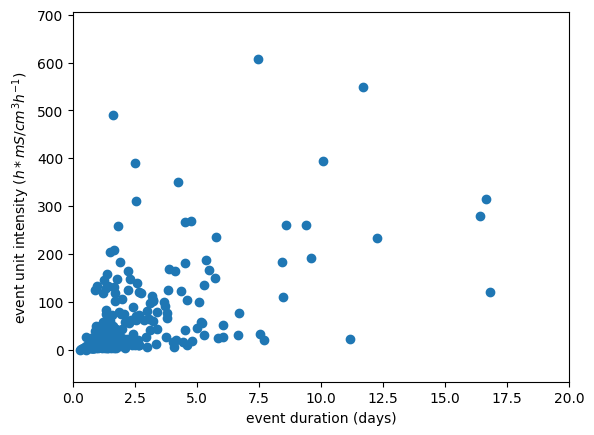

In [47]:
#plot intensity vs duration
fig, ax = plt.subplots()

ax.scatter(dur/24,inten_u)
ax.set_xlabel('event duration (days)')
ax.set_ylabel('event unit intensity ($h*mS/cm^3 h^{-1}$)')
ax.set_xlim(0,20)

(0.0, 8.0)

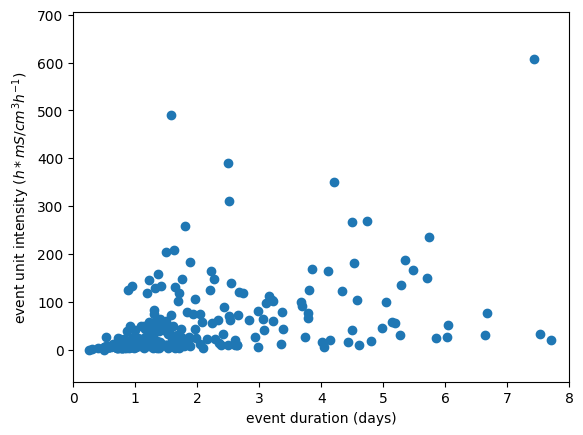

In [48]:
#plot intensity vs duration
fig, ax = plt.subplots()

ax.scatter(dur/24,inten_u)
ax.set_xlabel('event duration (days)')
ax.set_ylabel('event unit intensity ($h*mS/cm^3 h^{-1}$)')
ax.set_xlim(0,8)

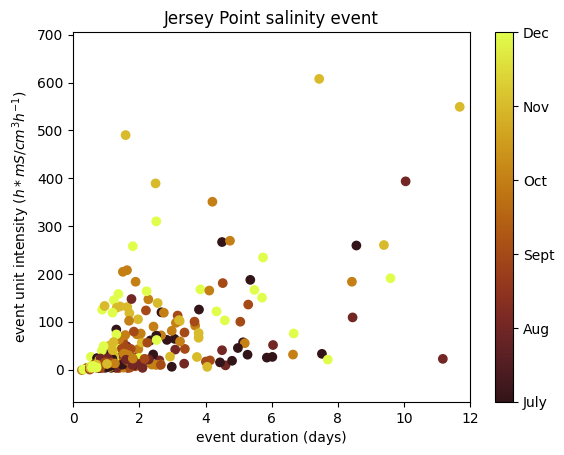

In [50]:
#add colorbar
fig, ax = plt.subplots()

pts=ax.scatter(dur/24,inten_u,c=x[lind].month,cmap=cmocean.cm.solar)
ax.set_xlabel('event duration (days)')
ax.set_ylabel('event unit intensity ($h*mS/cm^3 h^{-1}$)')
ax.set_xlim(0,12)
ax.set_title('Jersey Point salinity event')
cbar=fig.colorbar(pts, ax=ax)
cbar.set_ticks(ticks=np.arange(7,13), labels=['July','Aug','Sept','Oct','Nov','Dec'])
plt.show()

In [ ]:
#for each event duration bin, fit a cdf for frequency versus intensity 


In [ ]:
#make intensity duration frequency plot


# try finding peaks with wavelet transform function instead (actually this function does not find the widths of the events)

In [36]:
wtwidths=np.linspace(2,maxw)

In [37]:
wtwidths

NameError: name 'wtwidths' is not defined

In [38]:
wtwidths=np.linspace(2,maxw)
wtpeakspr = find_peaks_cwt(df_f_wo21.pr.dropna().values,wtwidths)

y=df_f_wo21.pr.dropna().values
x=df_f_wo21.pr.dropna().index
left=wtpropertiespr["left_ips"]
right=wtpropertiespr["right_ips"]
lind=np.round(left).astype(int)
rind=np.round(right).astype(int)
fig,ax =plt.subplots(figsize=(24,8))
#ax.plot(x,y,color='grey')
ax.plot(x,y,color='grey')
ax.scatter(x[wtpeakspr], df_f_wo21.pr.dropna().iloc[wtpeakspr], label="Point Reyes",marker="x",color='k')
ax.set_title('wavelet transform')
ax.vlines(x=x[lind],ymin=0,ymax=y[lind])
ax.vlines(x=x[rind],ymin=0,ymax=y[rind])

ax.set_xlim([datetime(2012,8,1),datetime(2012,12,1)])
plt.show()

ValueError: too many values to unpack (expected 2)

In [ ]:
areavwt=np.array([])
fig,ax =plt.subplots(figsize=(24,8))
ax.plot(x,y,color='grey',linewidth=3)
ax.scatter(x[wtpeakspr], df_f_wo21.pr.dropna().iloc[wtpeakspr], label="Point Reyes",marker="x",color='k',linewidth=2)

for p in np.arange(0,len(lind)):
    #print(p)
    peak=y[lind[p]:rind[p]]
    total_area = trapz(peak,dx=0.5) #need to pass the values between the left and right
    #now subtract the area from 0 to the peak, straight line between y[lind[p]] and y[rind[p]], should be the same length as peak
    n_points=len(peak)
    peak_bottom=np.linspace(peak[0],peak[len(peak)-1],num=n_points,endpoint=True)
    area_bottom=trapz(peak_bottom,dx=0.5) #dx is half an hour
    area=total_area-area_bottom
    #print(area)
    areav=np.append(areav, area)
    #check that we are selecting the right area of the peak
    ax.plot(x[lind[p]:rind[p]],peak,linestyle='--',color='c',linewidth=3)
    ax.plot(x[lind[p]:rind[p]],peak_bottom,linestyle='--',color='m')
    ax.vlines(x=x[lind],ymin=0,ymax=y[lind])
    ax.vlines(x=x[rind],ymin=0,ymax=y[rind])
    #30 minute time resolution = .5 hours
areavwt #units of elevation in m X time in hours


ax.set_xlim([datetime(2012,8,1),datetime(2012,12,31)])
plt.show()

In [46]:
# np.rint(lind).astype(int)

array([  136,   538,   626,   854,  1040,  1217,  1545,  1977,  1944,
        2519,  2761,  2866,  3054,  3189,  3432,  4081,  4402,  4807,
        5216,  5304,  5195,  5703,  5813,  6113,  6223,  6634,  6815,
        7107,  7202,  7167,  7374,  7506,  7831,  7948,  8052,  8280,
        8404,  8508,  8665,  8832,  8890,  9088,  9416,  9515,  9774,
       10091, 11007, 11174, 11122, 11391, 11803, 12098, 12519, 12719,
       12703, 12871, 13513, 13970, 13943, 14289, 14498, 14759, 15035,
       15017, 15425, 15465, 15608, 15761, 15966, 16243, 16914, 17085,
       17311, 17375, 17664, 17798, 17951, 18286, 18370, 18515, 18606,
       18810, 19279, 19646, 19947, 20148, 19826, 20748, 20938, 21105,
       21241, 21336, 21544, 22395, 22619, 22824, 22931, 23196, 23482,
       23955, 24127, 24384, 24540, 24922, 25076, 25207, 25315, 25458,
       25663, 25840, 26549, 26618, 26863, 26831, 27195, 27490, 27710,
       27702, 28005, 28229, 28747, 28935, 29800, 30014, 30209, 30373,
       30734, 30803,

In [31]:
#first find the datetimes with peaks at all locations, store them in logical columns e.g. pr_peak
#seems to be using the whole summer as a peak sometimes, set max width of 2 months 
maxw=60*24*4
minw=2
peakspr, propertiespr = find_peaks(df_f_wo21.pr.dropna().values, height=0,width=(2,maxw))#,width=(0,maxw)) #this just gives the x locations of the peaks, need to convert to logical
pr_indices = df_f_wo21.pr.dropna().index
peaksjp, propertiesjp = find_peaks(df_f_wo21.jp.values, prominence=10)#,width=(0,maxw))
peakshol2, propertieshol2 = find_peaks(df_f_wo21.hol2.values, prominence=10)#,width=(0,maxw))
peaksfrk, propertiesfrk = find_peaks(df_f_wo21.frk.values, prominence=10)#,width=(0,maxw))
#peakshol210, _ = find_peaks(df_f_wo21.hol2.values, prominence=10)
idx=np.arange(0,len(df_f_wo21.pr.values))#has the same shape as the first argument
df_f_wo21['pr_peak']=np.isin(df_f_wo21.index,pr_indices[peakspr]) #for this one need to map from the nan dropped list to full list
df_f_wo21['pr_left']=
df_f_wo21['pr_right']
df_f_wo21['pr_area']
df_f_wo21['jp_peak']=np.isin(idx,peaksjp)
df_f_wo21['hol2_peak']=np.isin(idx,peakshol2)
df_f_wo21['frk_peak']=np.isin(idx,peaksfrk)
df_f_wo21

,pr,jp,frk,hol2,datetime,month,year,pr_peak,jp_peak,hol2_peak,frk_peak
datetime,,,,,,,,,,,
2012-02-13 00:00:00,NaN,NaN,NaN,NaN,NaT,NaN,NaN,False,False,False,False
2012-02-13 00:15:00,NaN,NaN,NaN,NaN,NaT,NaN,NaN,False,False,False,False
2012-02-13 00:30:00,NaN,NaN,NaN,NaN,NaT,NaN,NaN,False,False,False,False
2012-02-13 00:45:00,NaN,NaN,NaN,NaN,NaT,NaN,NaN,False,False,False,False
2012-02-13 01:00:00,NaN,NaN,NaN,NaN,NaT,NaN,NaN,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...
2023-11-17 23:00:00,0.206520,1067.342768,205.590816,216.022549,2023-11-17 23:00:00,11.0,2023.0,False,False,False,False
2023-11-17 23:15:00,NaN,1069.722160,205.787840,216.071901,2023-11-17 23:15:00,11.0,2023.0,False,False,False,False
2023-11-17 23:30:00,0.207101,1072.129574,205.988822,216.120777,2023-11-17 23:30:00,11.0,2023.0,False,False,False,False


In [32]:
print(df_f_wo21['pr_peak'].sum())
print(df_f_wo21['jp_peak'].sum())
print(df_f_wo21['frk_peak'].sum())
print(df_f_wo21['hol2_peak'].sum())

360
283
56
106


In [33]:
#make an array of ones to multiply by the true false
ov=np.ones_like(df_f_wo21['pr_peak'].values)

In [34]:
df_f_wo21['pr_peak'].values*1

array([0, 0, 0, ..., 0, 0, 0])

In [35]:
# as a first pass, how many events are there where there is a true value in all columns in the 24 hours after the pr peak?
peak_pr24h=np.array([])
peak_jp24h=np.array([])
peak_hol224h=np.array([])
win=24 #number of samples in 24 hours
winh=win*5
count_j=0
count_h=0
for p in peakspr:
    #need to map this index back to the data frame
    x=pr_indices[p]
    x2=x+pd.Timedelta(hours=win)
    x3=x+pd.Timedelta(hours=winh)
    if df_f_wo21.jp_peak[x:x2].sum()>0:
        count_j=count_j+1
        if df_f_wo21.hol2_peak[x:x3].sum()>0:  
            count_h=count_h+1
            peak_pr24h=np.append(peak_pr24h,x)
            peak_jp24h=np.append(peak_jp24h,x+pd.Timedelta(minutes=df_f_wo21.jp_peak[x:x2].argmax()*15))
            peak_hol224h=np.append(peak_hol224h,x+pd.Timedelta(minutes=df_f_wo21.hol2_peak[x:x3].argmax()*15))
idx=np.arange(0,len(df_f_wo21.pr.values))
print(len(peak_pr24h))
print(count_j)
print(count_h)
df_f_wo21['all_peak_24h']=np.isin(idx,peak_pr24h)

51
139
51


(15553.0, 15675.0)

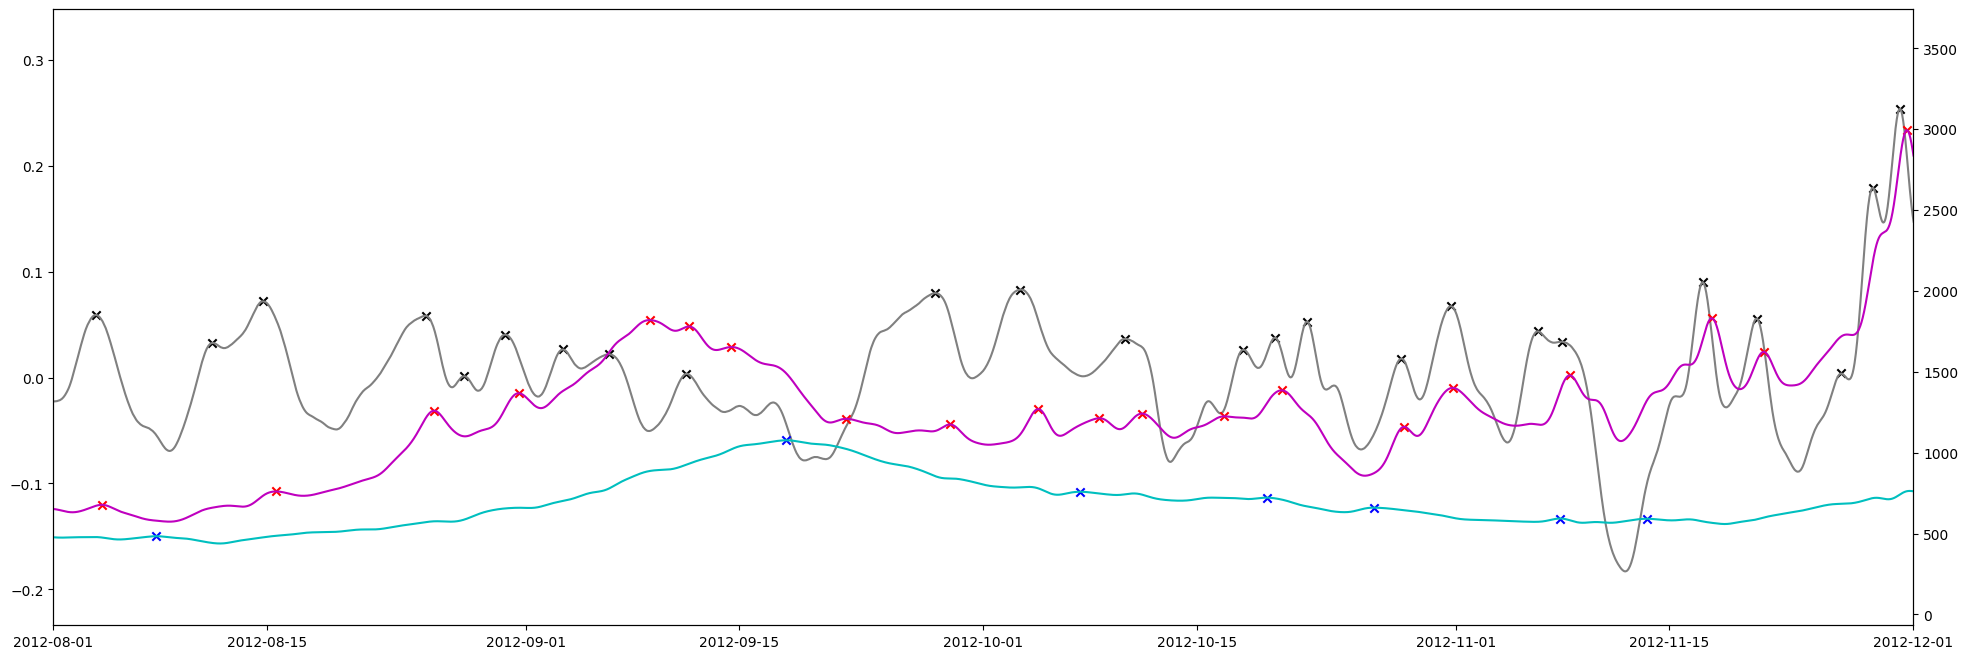

In [36]:
fig, ax =plt.subplots(figsize=(24,8))

ax.plot(pr_indices,df_f_wo21.pr.dropna(),color='grey')
ax.scatter(pr_indices[peakspr], df_f_wo21.pr.dropna().iloc[peakspr], label="Point Reyes",marker="x",color='k')
ax1=ax.twinx()
ax1.plot(df_f_wo21.jp,color='m')
ax1.scatter(df_f_wo21.datetime.iloc[peaksjp],df_f_wo21.jp.iloc[peaksjp],label="Jersey Point",marker="x",color='r')
ax1.plot(df_f_wo21.hol2,color='c')
ax1.scatter(df_f_wo21.datetime.iloc[peakshol2],df_f_wo21.hol2.iloc[peakshol2],label="Holland Cut",marker="x",color='b')
ax.set_xlim([datetime(2012,8,1),datetime(2012,12,1)])
ax1.set_xlim([datetime(2012,8,1),datetime(2012,12,1)])

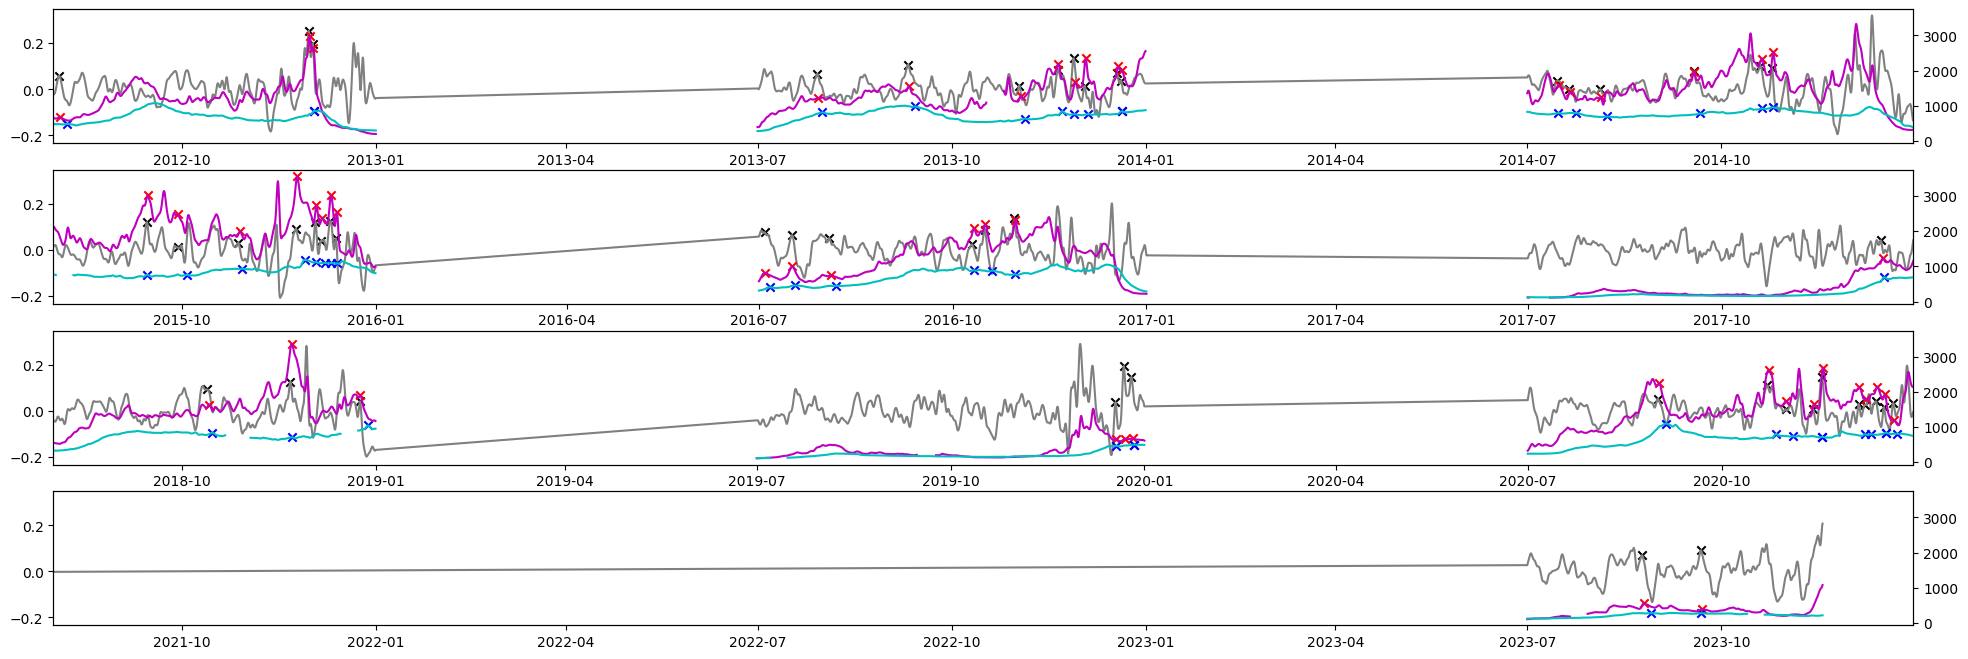

In [37]:
# try plotting these 19 events, split the period of time into 4 sections
fig, ax =plt.subplots(4,1,sharey=True,figsize=(24,8))

ax[0].plot(pr_indices,df_f_wo21.pr.dropna(),color='grey')
ax[0].scatter(df_f_wo21.datetime.loc[peak_pr24h], df_f_wo21.pr.loc[peak_pr24h], label="Point Reyes",marker="x",color='k')
ax1=ax[0].twinx()
ax1.plot(df_f_wo21.jp,color='m')
ax1.scatter(df_f_wo21.datetime.loc[peak_jp24h],df_f_wo21.jp.loc[peak_jp24h],label="Jersey Point",marker="x",color='r')
ax1.plot(df_f_wo21.hol2,color='c')
ax1.scatter(df_f_wo21.datetime.loc[peak_hol224h],df_f_wo21.hol2.loc[peak_hol224h],label="Holland Cut",marker="x",color='b')
ax[0].set_xlim([datetime(2012,8,1),datetime(2014,12,31)])
ax1.set_xlim([datetime(2012,8,1),datetime(2014,12,31)])

ax[1].plot(pr_indices,df_f_wo21.pr.dropna(),color='grey')
ax[1].scatter(df_f_wo21.datetime.loc[peak_pr24h], df_f_wo21.pr.loc[peak_pr24h], label="Point Reyes",marker="x",color='k')
ax2=ax[1].twinx()
ax2.plot(df_f_wo21.jp,color='m')
ax2.scatter(df_f_wo21.datetime.loc[peak_jp24h],df_f_wo21.jp.loc[peak_jp24h],label="Jersey Point",marker="x",color='r')
ax2.plot(df_f_wo21.hol2,color='c')
ax2.scatter(df_f_wo21.datetime.loc[peak_hol224h],df_f_wo21.hol2.loc[peak_hol224h],label="Holland Cut",marker="x",color='b')
ax[1].set_xlim([datetime(2015,8,1),datetime(2017,12,31)])
ax2.set_xlim([datetime(2015,8,1),datetime(2017,12,31)])

ax[2].plot(pr_indices,df_f_wo21.pr.dropna(),color='grey')
ax[2].scatter(df_f_wo21.datetime.loc[peak_pr24h], df_f_wo21.pr.loc[peak_pr24h], label="Point Reyes",marker="x",color='k')
ax3=ax[2].twinx()
ax3.plot(df_f_wo21.jp,color='m')
ax3.scatter(df_f_wo21.datetime.loc[peak_jp24h],df_f_wo21.jp.loc[peak_jp24h],label="Jersey Point",marker="x",color='r')
ax3.plot(df_f_wo21.hol2,color='c')
ax3.scatter(df_f_wo21.datetime.loc[peak_hol224h],df_f_wo21.hol2.loc[peak_hol224h],label="Holland Cut",marker="x",color='b')
ax[2].set_xlim([datetime(2018,8,1),datetime(2020,12,31)])
ax3.set_xlim([datetime(2018,8,1),datetime(2020,12,31)])

ax[3].plot(pr_indices,df_f_wo21.pr.dropna(),color='grey')
ax[3].scatter(df_f_wo21.datetime.loc[peak_pr24h], df_f_wo21.pr.loc[peak_pr24h], label="Point Reyes",marker="x",color='k')
ax4=ax[3].twinx()
ax4.plot(df_f_wo21.jp,color='m')
ax4.scatter(df_f_wo21.datetime.loc[peak_jp24h],df_f_wo21.jp.loc[peak_jp24h],label="Jersey Point",marker="x",color='r')
ax4.plot(df_f_wo21.hol2,color='c')
ax4.scatter(df_f_wo21.datetime.loc[peak_hol224h],df_f_wo21.hol2.loc[peak_hol224h],label="Holland Cut",marker="x",color='b')
ax[3].set_xlim([datetime(2021,8,1),datetime(2023,12,31)])
ax4.set_xlim([datetime(2021,8,1),datetime(2023,12,31)])

plt.show()

In [38]:
#what if we just look at where Jersey Point has a peak and use those events
peak_pr24h=np.array([])
peak_jp24h=np.array([])
#peak_hol224h=np.array([])
win=24 #number of hours to include in searc

count_j=0
count_h=0
for p in peakspr:
    #need to map this index back to the data frame
    x=pr_indices[p]
    x2=x+pd.Timedelta(hours=win)
    if df_f_wo21.jp_peak[x:x2].sum()>0:
        count_j=count_j+1  
        peak_pr24h=np.append(peak_pr24h,x)
        peak_jp24h=np.append(peak_jp24h,x+pd.Timedelta(minutes=df_f_wo21.jp_peak[x:x2].argmax()*15))
idx=np.arange(0,len(df_f_wo21.pr.values))
print(len(peak_pr24h))
print(count_j)
df_f_wo21['all_peak_24h']=np.isin(idx,peak_pr24h)

139
139


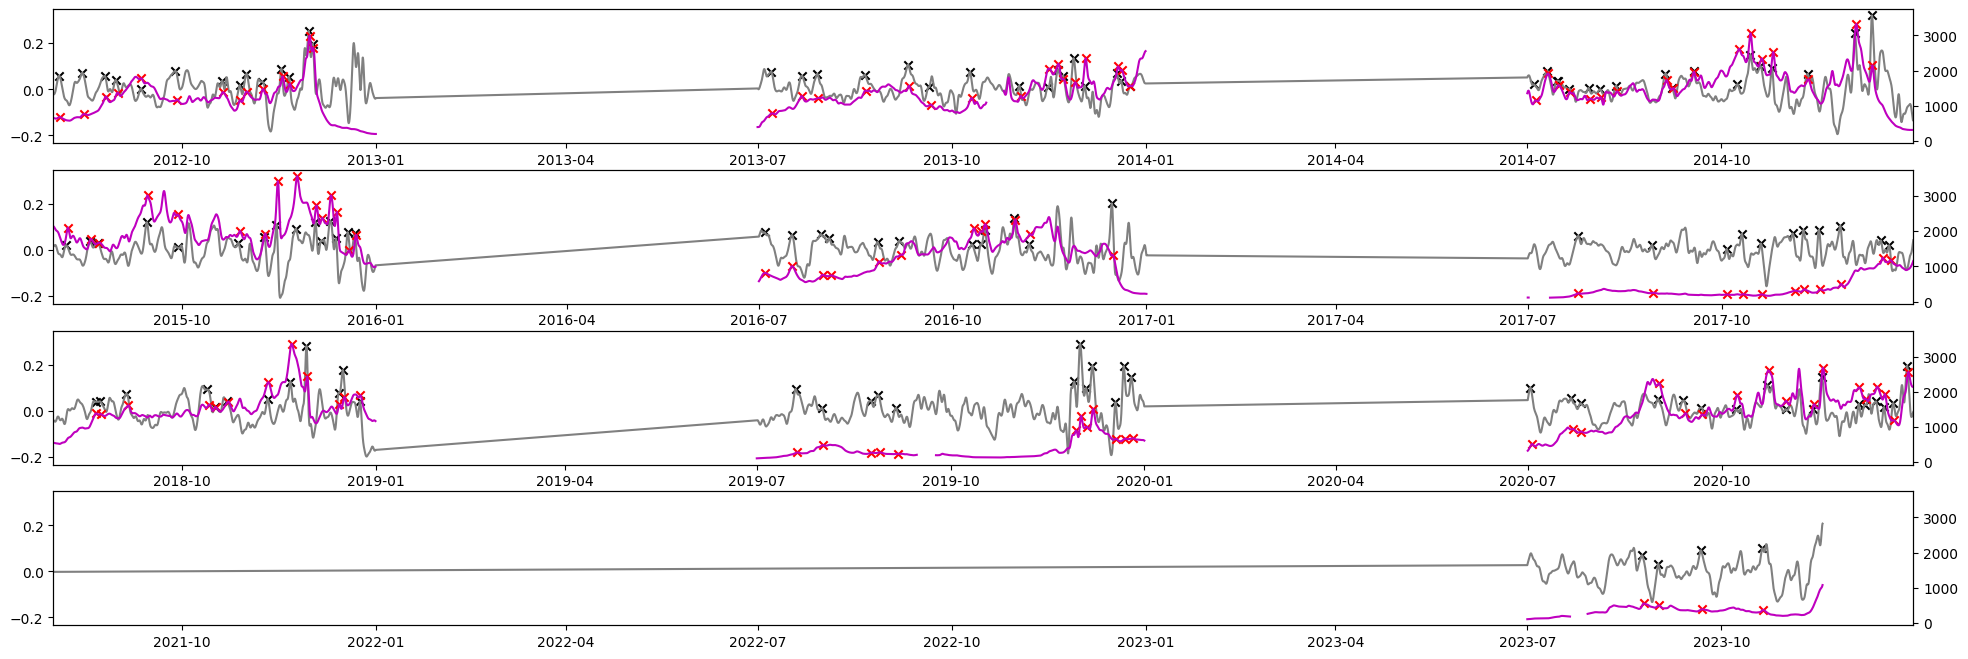

In [39]:
# try plotting these 19 events, split the period of time into 4 sections
fig, ax =plt.subplots(4,1,sharey=True,figsize=(24,8))

ax[0].plot(pr_indices,df_f_wo21.pr.dropna(),color='grey')
ax[0].scatter(df_f_wo21.datetime.loc[peak_pr24h], df_f_wo21.pr.loc[peak_pr24h], label="Point Reyes",marker="x",color='k')
ax1=ax[0].twinx()
ax1.plot(df_f_wo21.jp,color='m')
ax1.scatter(df_f_wo21.datetime.loc[peak_jp24h],df_f_wo21.jp.loc[peak_jp24h],label="Jersey Point",marker="x",color='r')
ax[0].set_xlim([datetime(2012,8,1),datetime(2014,12,31)])
ax1.set_xlim([datetime(2012,8,1),datetime(2014,12,31)])

ax[1].plot(pr_indices,df_f_wo21.pr.dropna(),color='grey')
ax[1].scatter(df_f_wo21.datetime.loc[peak_pr24h], df_f_wo21.pr.loc[peak_pr24h], label="Point Reyes",marker="x",color='k')
ax2=ax[1].twinx()
ax2.plot(df_f_wo21.jp,color='m')
ax2.scatter(df_f_wo21.datetime.loc[peak_jp24h],df_f_wo21.jp.loc[peak_jp24h],label="Jersey Point",marker="x",color='r')
ax[1].set_xlim([datetime(2015,8,1),datetime(2017,12,31)])
ax2.set_xlim([datetime(2015,8,1),datetime(2017,12,31)])

ax[2].plot(pr_indices,df_f_wo21.pr.dropna(),color='grey')
ax[2].scatter(df_f_wo21.datetime.loc[peak_pr24h], df_f_wo21.pr.loc[peak_pr24h], label="Point Reyes",marker="x",color='k')
ax3=ax[2].twinx()
ax3.plot(df_f_wo21.jp,color='m')
ax3.scatter(df_f_wo21.datetime.loc[peak_jp24h],df_f_wo21.jp.loc[peak_jp24h],label="Jersey Point",marker="x",color='r')
ax[2].set_xlim([datetime(2018,8,1),datetime(2020,12,31)])
ax3.set_xlim([datetime(2018,8,1),datetime(2020,12,31)])

ax[3].plot(pr_indices,df_f_wo21.pr.dropna(),color='grey')
ax[3].scatter(df_f_wo21.datetime.loc[peak_pr24h], df_f_wo21.pr.loc[peak_pr24h], label="Point Reyes",marker="x",color='k')
ax4=ax[3].twinx()
ax4.plot(df_f_wo21.jp,color='m')
ax4.scatter(df_f_wo21.datetime.loc[peak_jp24h],df_f_wo21.jp.loc[peak_jp24h],label="Jersey Point",marker="x",color='r')
ax[3].set_xlim([datetime(2021,8,1),datetime(2023,12,31)])
ax4.set_xlim([datetime(2021,8,1),datetime(2023,12,31)])

plt.show()

In [ ]:
#calculate the duration of the jersey point peak and the area under the curve


In [ ]:
#compare with intensity and duration of the point reyes events

(16283.0, 16405.0)

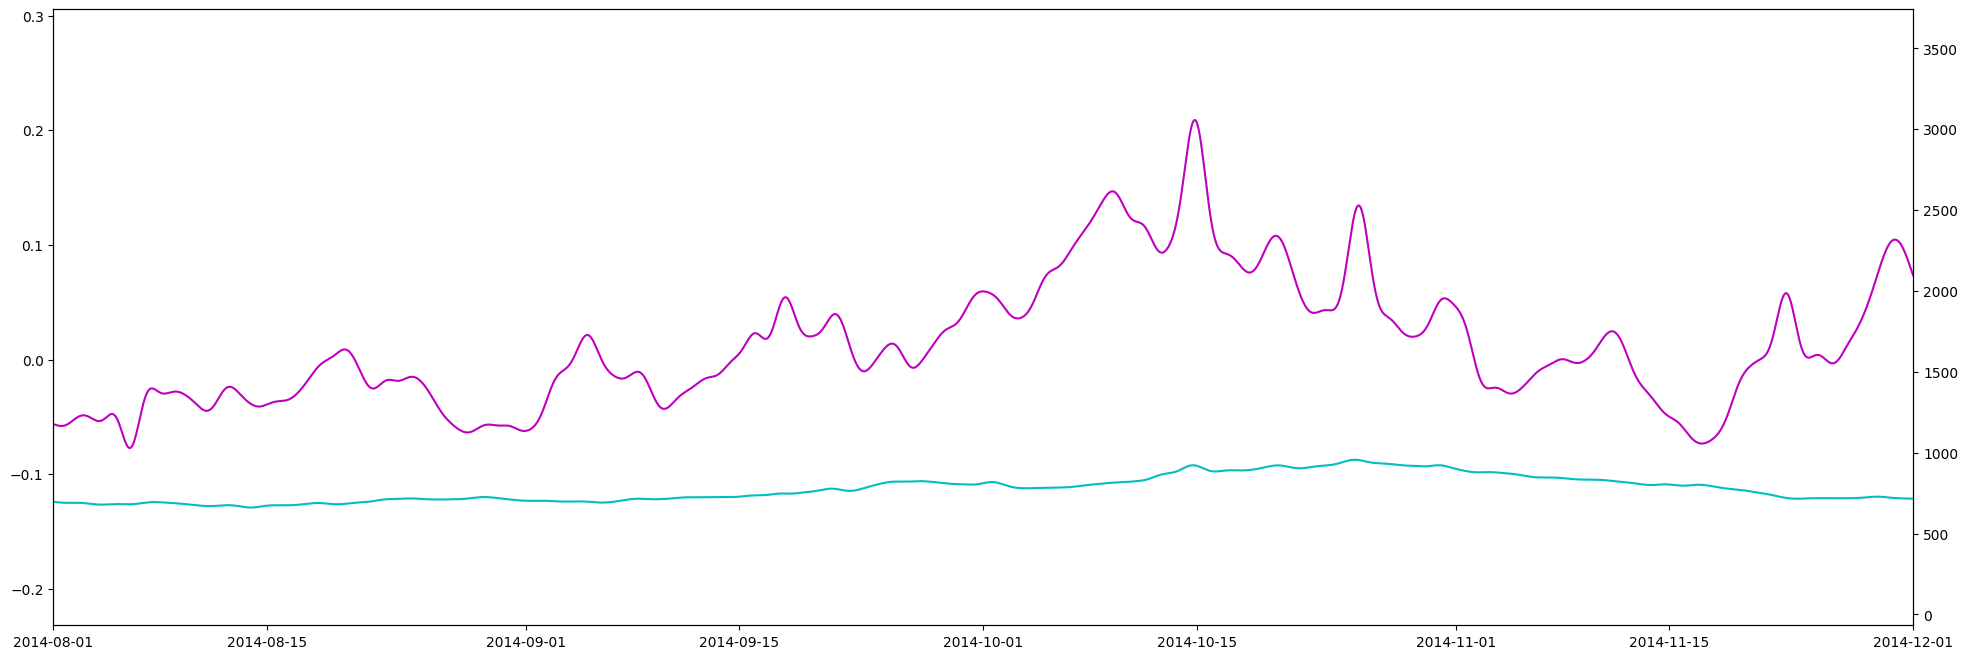

In [32]:
fig, ax =plt.subplots(figsize=(24,8))

ax.plot(df_f_wo21.pr,color='grey')
ax.scatter(df_f_wo21.datetime.iloc[peak_pr24h], df_f_wo21.pr.iloc[peak_pr24h], label="Point Reyes",marker="x",color='k')
ax.vlines(df_f_wo21.datetime.iloc[peak_pr24h], -0.2, 0.2, color='k')
ax1=ax.twinx()
ax1.plot(df_f_wo21.jp,color='m')
ax1.scatter(df_f_wo21.datetime.iloc[peak_jp24h],df_f_wo21.jp.iloc[peak_jp24h],label="Jersey Point",marker="x",color='r')
ax1.plot(df_f_wo21.hol2,color='c')
ax1.scatter(df_f_wo21.datetime.iloc[peak_hol224h],df_f_wo21.hol2.iloc[peak_hol224h],label="Holland Cut",marker="x",color='b')

# #what if we also plot all of the prominent hol2 peaks
# ax1.scatter(df_f_wo21.datetime.iloc[peakshol224h],df_f_wo21.hol2.iloc[peakshol210],marker="*",color='k')

ax.set_xlim([datetime(2014,8,1),datetime(2014,12,1)])
ax1.set_xlim([datetime(2014,8,1),datetime(2014,12,1)])

(19205.0, 19327.0)

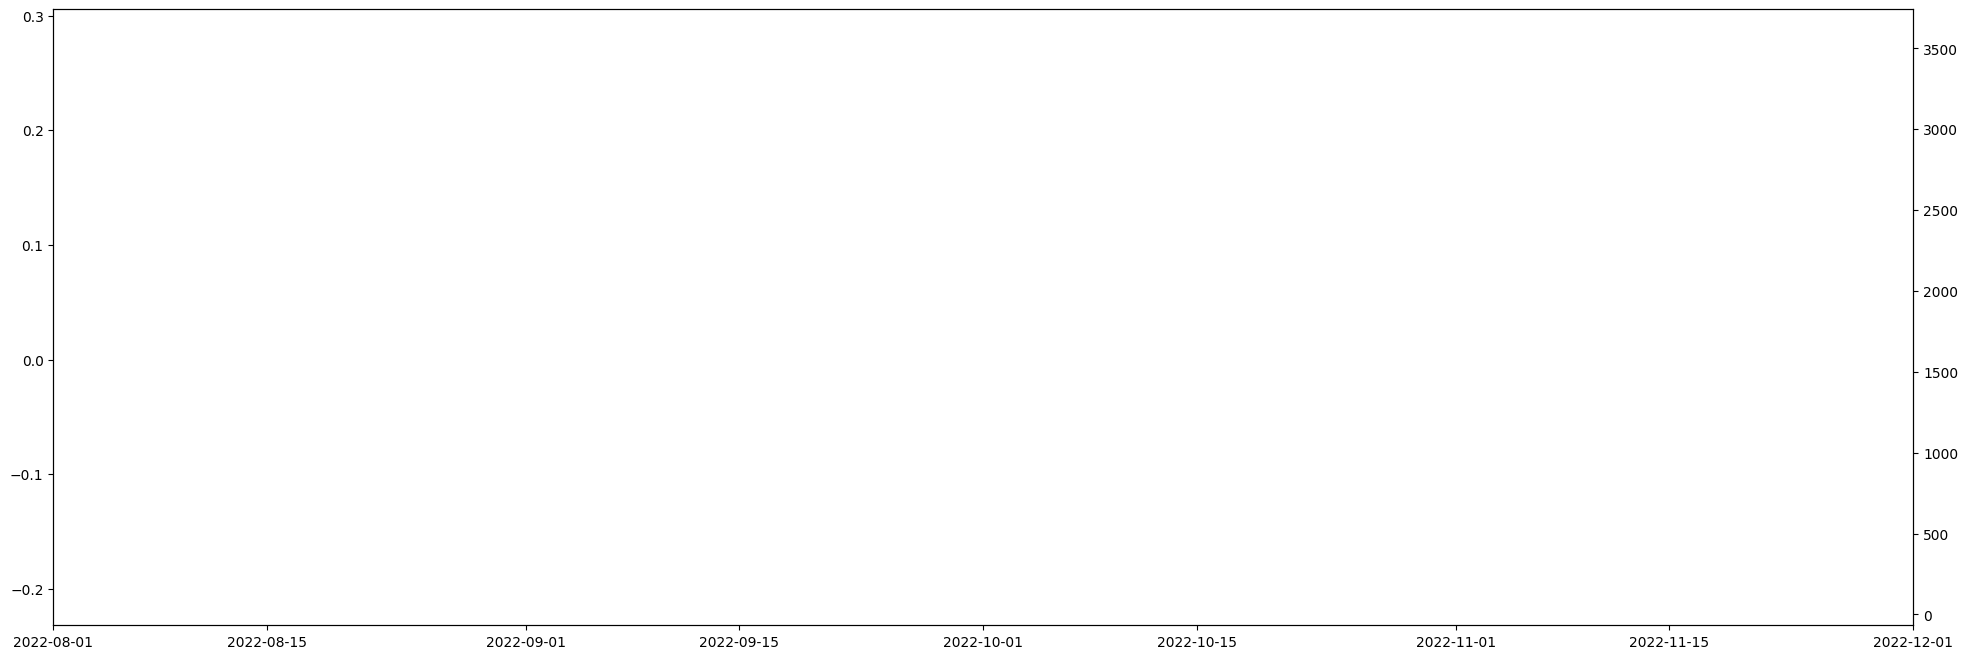

In [33]:
fig, ax =plt.subplots(figsize=(24,8))

ax.plot(df_f_wo21.pr,color='grey')
ax.scatter(df_f_wo21.datetime.iloc[peak_pr24h], df_f_wo21.pr.iloc[peak_pr24h], label="Point Reyes",marker="x",color='k')
ax.vlines(df_f_wo21.datetime.iloc[peak_pr24h], -0.2, 0.2, color='k')
ax1=ax.twinx()
ax1.plot(df_f_wo21.jp,color='m')
ax1.scatter(df_f_wo21.datetime.iloc[peak_jp24h],df_f_wo21.jp.iloc[peak_jp24h],label="Jersey Point",marker="x",color='r')
ax1.plot(df_f_wo21.hol2,color='c')
ax1.scatter(df_f_wo21.datetime.iloc[peak_hol224h],df_f_wo21.hol2.iloc[peak_hol224h],label="Holland Cut",marker="x",color='b')

# #what if we also plot all of the prominent hol2 peaks
# ax1.scatter(df_f_wo21.datetime.iloc[peakshol210],df_f_wo21.hol2.iloc[peakshol210],marker="*",color='k')

ax.set_xlim([datetime(2022,8,1),datetime(2022,12,1)])
ax1.set_xlim([datetime(2022,8,1),datetime(2022,12,1)])

(16283.0, 19692.0)

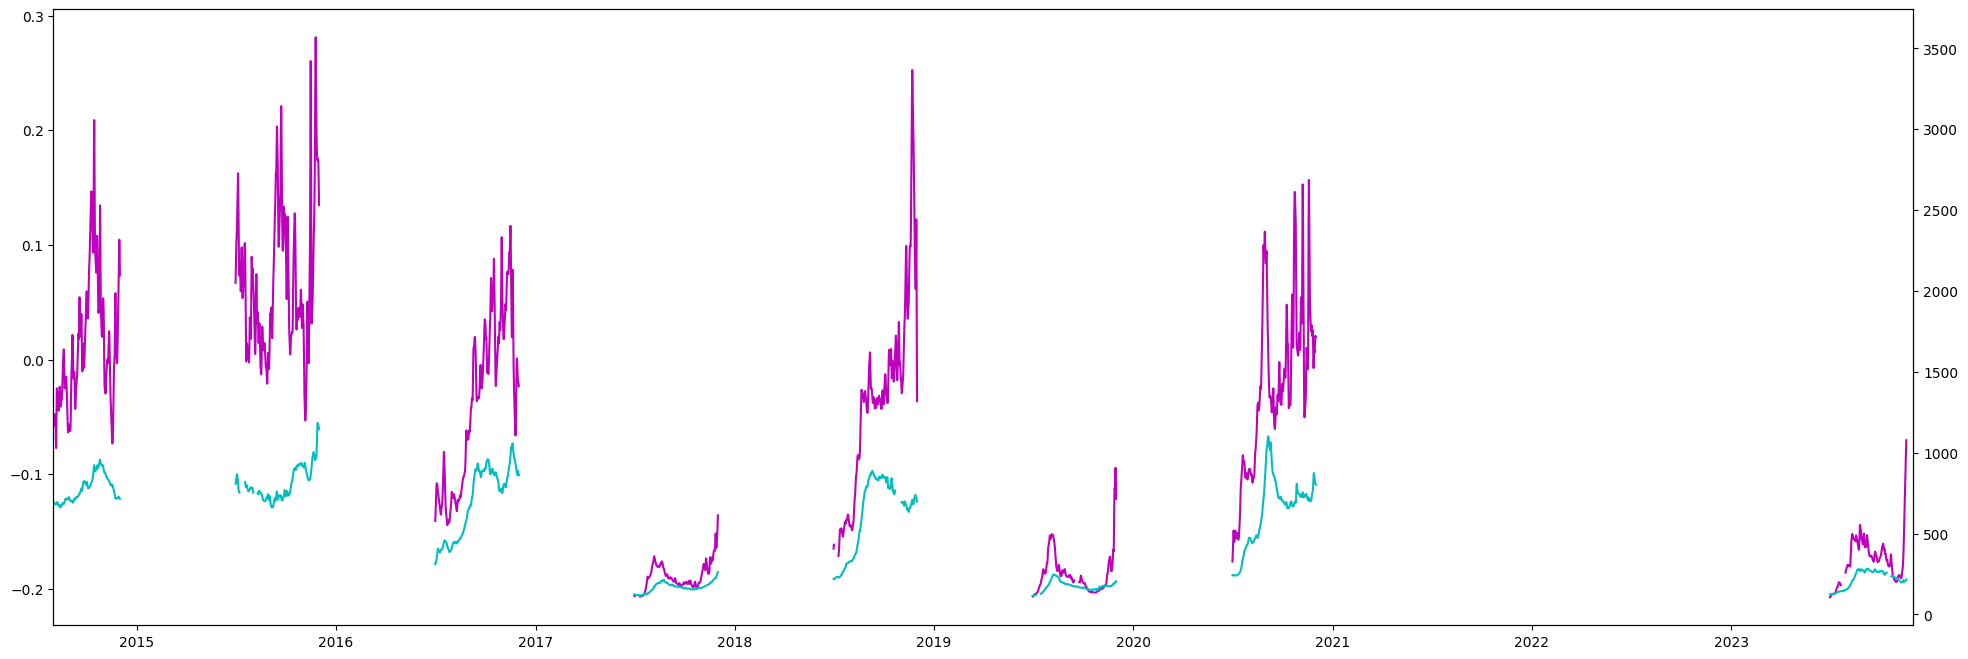

In [34]:
fig, ax =plt.subplots(figsize=(24,8))

ax.plot(df_f_wo21.pr,color='grey')
ax.scatter(df_f_wo21.datetime.iloc[peak_pr24h], df_f_wo21.pr.iloc[peak_pr24h], label="Point Reyes",marker="x",color='k')
ax.vlines(df_f_wo21.datetime.iloc[peak_pr24h], -0.2, 0.2, color='k')
ax1=ax.twinx()
ax1.plot(df_f_wo21.jp,color='m')
ax1.scatter(df_f_wo21.datetime.iloc[peak_jp24h],df_f_wo21.jp.iloc[peak_jp24h],label="Jersey Point",marker="x",color='r')
ax1.plot(df_f_wo21.hol2,color='c')
ax1.scatter(df_f_wo21.datetime.iloc[peak_hol224h],df_f_wo21.hol2.iloc[peak_hol224h],label="Holland Cut",marker="x",color='b')

# #what if we also plot all of the prominent hol2 peaks
# ax1.scatter(df_f_wo21.datetime.iloc[peakshol210],df_f_wo21.hol2.iloc[peakshol210],marker="*",color='k')

ax.set_xlim([datetime(2014,8,1),datetime(2023,12,1)])
ax1.set_xlim([datetime(2014,8,1),datetime(2023,12,1)])